<a href="https://www.kaggle.com/code/masatomurakawamm/titanic-deeplearning-optimization-eda-automl?scriptVersionId=99341243" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
# [Titanic - Machine Learning from Disaster][1]

**Goal:** To predict if a passenger survived the sinking of the Titanic or not.

---
### **The aim of this notebook is to**
- **1. Conduct Exploratory Data Analysis (EDA) and Feature Engineering.**
- **2. Create and train a Deep Learning model with TensorFlow.**
- **3. Optimize the neural network architecture with Optuna.**
- **4. Learn how to use TPU.**
- **5. Learn how to use AutoML (H2O AutoML).**
---
#### **Note:** 
- You can run this notebook on CPU, GPU, and TPU without changing codes.
- In this notebook, training model on TPU takes more time than on GPU or CPU, because of the small batch size, small datasets, ect. Please understand that I didn't optimize the experiment parameters for TPU.
- It would take much time to run optimization codes with many trials on TPU, so it is recommended to run on CPU or GPU.

---
#### **References:**
 Thanks to previous great codes, blogs, and notebooks.
- [How to Use Kaggle: Tensor Processing Units (TPUs)][2]
- [AutoML: Automatic Machine Learning][5]
- [H2O AutoML Tutorial][6]
- [Automated Machine Learning with H2O][7]

---
#### **My Previous Notebooks:**
- This competition is a basic classification task. If you are also interested in basic regression task, **[my notebook of House Prices competition][3]** would be useful.
- If you would like to know more about other deep learning models for tabular data, you can find it in **[my notebook of Spaceship Titanic competition][4]**.

---
### **If you find this notebook useful, or when you copy&edit this notebook, please do give me an upvote. It helps me keep up my motivation.**

---
[1]: https://www.kaggle.com/competitions/titanic
[2]: https://www.kaggle.com/docs/tpu
[3]: https://www.kaggle.com/code/masatomurakawamm/houseprices-deeplearning-eda-automl-pycaret
[4]: https://www.kaggle.com/code/masatomurakawamm/spaceshiptitanic-eda-tabtransformer-tensorflow
[5]: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
[6]: https://github.com/h2oai/h2o-tutorials/tree/master/h2o-world-2017/automl
[7]: https://towardsdatascience.com/automated-machine-learning-with-h2o-258a2f3a203f

<h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>0. TABLE OF CONTENTS</center></h1>

<ul class="list-group" style="list-style-type:none;">
    <li><a href="#1" class="list-group-item list-group-item-action">1. Settings</a></li>
    <li><a href="#2" class="list-group-item list-group-item-action">2. Data Loading</a></li>
    <li><a href="#3" class="list-group-item list-group-item-action">3. EDA and Feature Engineering</a>
        <ul class="list-group" style="list-style-type:none;">
            <li><a href="#3.1" class="list-group-item list-group-item-action">3.1 AutoEDA with Sweetviz</a></li>
            <li><a href="#3.2" class="list-group-item list-group-item-action">3.2 Feature Selection</a></li>
            <li><a href="#3.3" class="list-group-item list-group-item-action">3.3 Target Distribution</a></li>
            <li><a href="#3.4" class="list-group-item list-group-item-action">3.4 Numerical Features</a></li>
            <li><a href="#3.5" class="list-group-item list-group-item-action">3.5 Categorical Features</a></li>
            <li><a href="#3.6" class="list-group-item list-group-item-action">3.6 Validation Split</a></li>
        </ul>
    </li>
    <li><a href="#4" class="list-group-item list-group-item-action">4. Deep Learning</a>
        <ul class="list-group" style="list-style-type:none;">
            <li><a href="#4.1" class="list-group-item list-group-item-action">4.1 Creating Dataset</a></li>
            <li><a href="#4.2" class="list-group-item list-group-item-action">4.2 Creating Model</a></li>
            <li><a href="#4.3" class="list-group-item list-group-item-action">4.3 Training Model</a></li>
            <li><a href="#4.4" class="list-group-item list-group-item-action">4.4 Inference</a></li>
        </ul>
    </li>
    <li><a href="#5" class="list-group-item list-group-item-action">5. Optimization</a></li>
    <li><a href="#6" class="list-group-item list-group-item-action">6. Cross Validation and Ensebmling</a></li>
    <li><a href="#7" class="list-group-item list-group-item-action">7. AutoML</a>
        <ul class="list-group" style="list-style-type:none;">
            <li><a href="#7.1" class="list-group-item list-group-item-action">7.1 Set up</a></li>
            <li><a href="#7.2" class="list-group-item list-group-item-action">7.2 Create Training Data</a></li>
            <li><a href="#7.3" class="list-group-item list-group-item-action">7.3 Run AutoML</a></li>
            <li><a href="#7.4" class="list-group-item list-group-item-action">7.4 Explainability</a></li>
        </ul>
    </li>
</ul>

<a id ="1"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>1. Settings</center></h1>

In [1]:
## Parameters
data_config = {'train.csv': '../input/titanic/train.csv',
               'test.csv': '../input/titanic/test.csv',
               'gender_submission.csv': '../input/titanic/gender_submission.csv',
              }

exp_config = {'competition_name': 'titanic',
              'n_splits': 5,
              'normalization': 'Robust',
              'encoding': 'one_hot',
              'n_sample_per_TPU_core': 16,
              'batch_size': 128,
              'learning_rate': 5e-4,
              'label_smoothing': 0.01,
              'train_epochs': 100,
              'checkpoint_filepath': './tmp/model/exp.ckpt',
              'cross_validation': True,
             }

model_config = {'model_input_shape': (57, ),
                'model_units': [64, 48, 32],
                'dropout_rates': [0., 0., 0.],
               }

opt_config = {'opt_flg': True,
              'opt_trials': 30,
              'opt_epochs': 60,
              'opt_batch_size': 256}

print('Parameters setted!')

Parameters setted!


In [2]:
## Import dependencies 
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import os
import pathlib
import gc
import sys
import re
import math 
import random
import time 
import datetime as dt
import pprint
from tqdm import tqdm 

print('Import done!')

Import done!


In [3]:
## For reproducible results    
def seed_all(s):
    random.seed(s)
    np.random.seed(s)
    tf.random.set_seed(s)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['PYTHONHASHSEED'] = str(s) 
    print('Seeds setted!')
    
global_seed = 42
seed_all(global_seed)

Seeds setted!


---
# [TPU] Distribution Strategy #

A TPU has eight different *cores* and each of these cores acts as its own accelerator. (A TPU is sort of like having eight GPUs in one machine.) We tell TensorFlow how to make use of all these cores at once through a **distribution strategy**. Run the following cell to create the distribution strategy that we'll later apply to our model. We'll use the distribution strategy when we create our neural network model. Then, TensorFlow will distribute the training among the eight TPU cores by creating eight different replicas of the model, one for each core.

In [4]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


---

<a id ="2"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>2. Data Loading</center></h1>

---
## [TPU] Loading the Competition Data ##

When used with TPUs, datasets need to be stored in a [Google Cloud Storage bucket](https://cloud.google.com/storage/). You can use data from any public GCS bucket by giving its path just like you would data from `'/kaggle/input'`. The following will retrieve the GCS path for this competition's dataset.

In [5]:
competition_name = exp_config['competition_name']

## Get GCS Path
from kaggle_datasets import KaggleDatasets

if tpu:
    DATA_DIR = KaggleDatasets().get_gcs_path(competition_name) 
    
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    
    for file_path in tf.io.gfile.glob(os.path.join(DATA_DIR, "*")):
        file_name = file_path.split('/')[-1]
        data_config[file_name] = file_path
    
else:
    DATA_DIR = '/kaggle/input/' + competition_name
    save_locally = None
    load_locally = None

print(f"Data Directory Path: {DATA_DIR}\n")
print("Contents of Data Directory:")
for file in tf.io.gfile.glob(os.path.join(DATA_DIR, "*")):
    print(f"\t{file}")

Data Directory Path: /kaggle/input/titanic

Contents of Data Directory:
	/kaggle/input/titanic/train.csv
	/kaggle/input/titanic/test.csv
	/kaggle/input/titanic/gender_submission.csv


After Loading data, we can conduct EDA or Feature Engineering just as like on CPU/GPU.

---

### [File and Data Field Descriptions](https://www.kaggle.com/competitions/titanic/data)

- **train.csv** - the training set
- **test.csv** - the test set
- **gender_submission.csv** - a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like


---
### [Submission & Evaluation](https://www.kaggle.com/competitions/titanic/overview/evaluation)

-  For each in the test set, you must predict a 0 or 1 value for the variable. Your score is the percentage of passengers you correctly predict. This is known as accuracy.

In [6]:
## Data Loading
train_df = pd.read_csv(data_config['train.csv'])
test_df = pd.read_csv(data_config['test.csv'])
submission_df = pd.read_csv(data_config['gender_submission.csv'])

print(f'train_length: {len(train_df)}')
print(f'test_lenght: {len(test_df)}')
print(f'submission_length: {len(submission_df)}')

train_length: 891
test_lenght: 418
submission_length: 418


In [7]:
## Null Value Check
print('train_df.info()'); print(train_df.info(), '\n')
print('test_df.info()'); print(test_df.info(), '\n')

## train_df Check
train_df.head()

train_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None 

test_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<a id ="3"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>3. EDA and Feature Engineering</center></h1>

<a id ="3.1"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.1 AutoEDA with Sweetviz</center></h2>

In [8]:
## Import dependencies
!pip install -U -q sweetviz 
import sweetviz
print('import done!')

import done!


                                             |          | [  0%]   00:00 -> (? left)


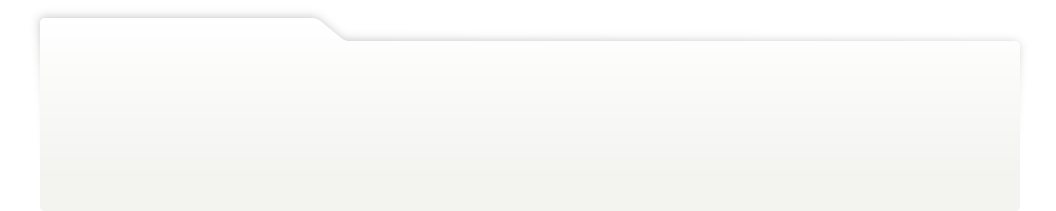
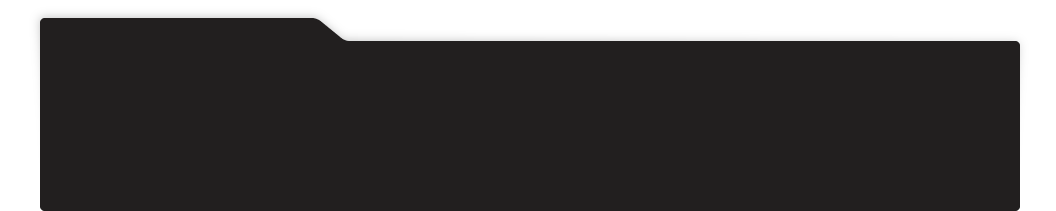
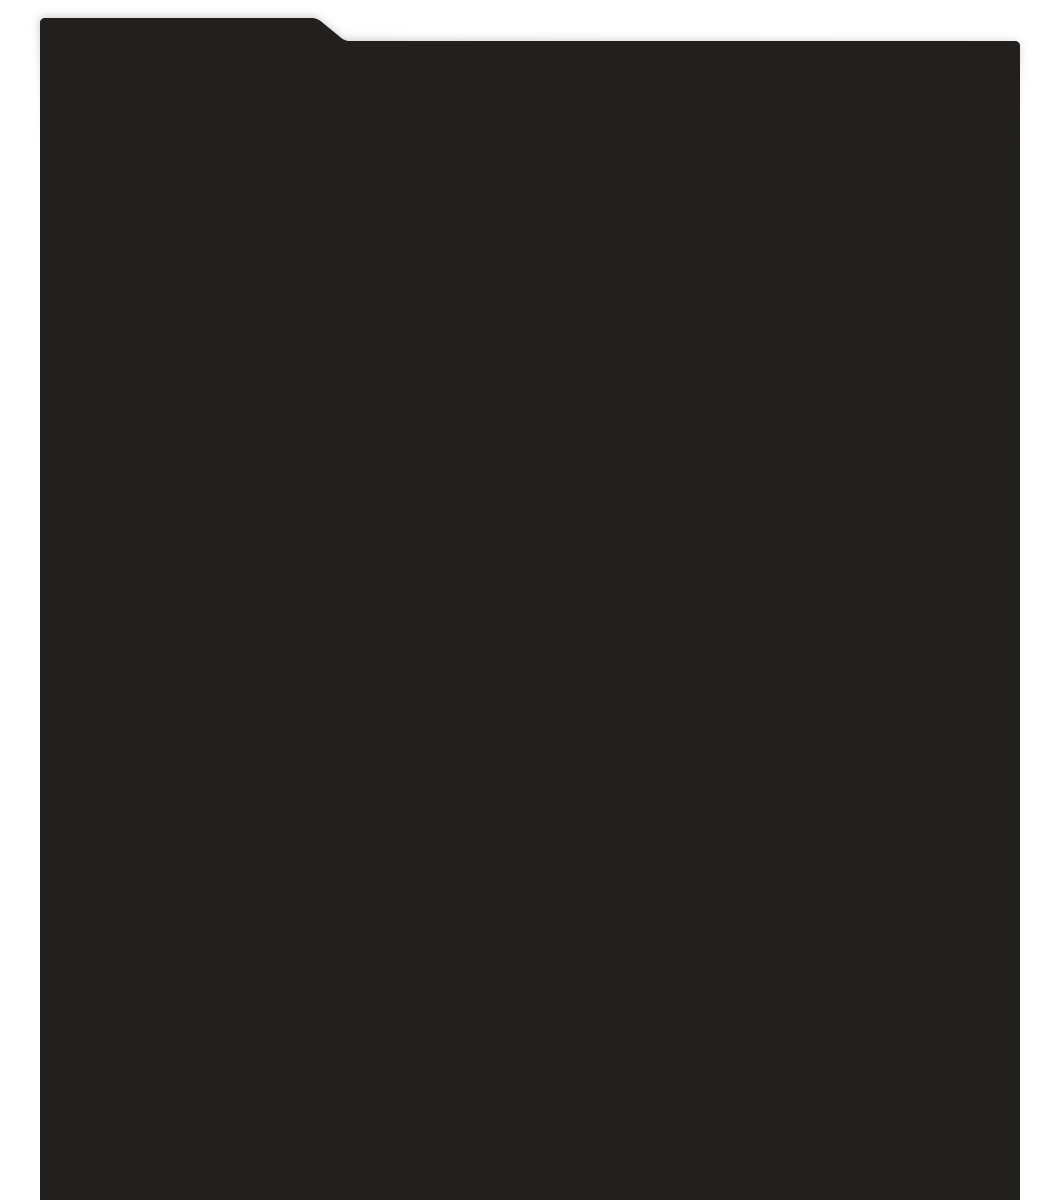
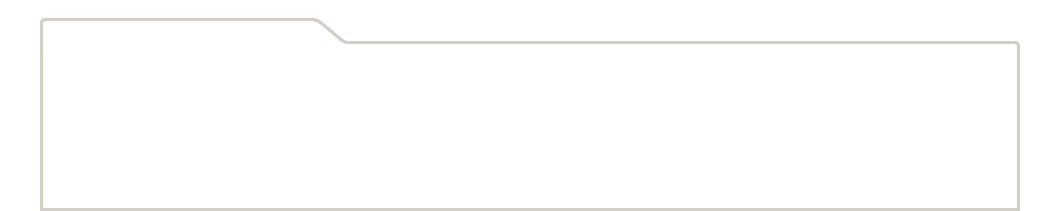
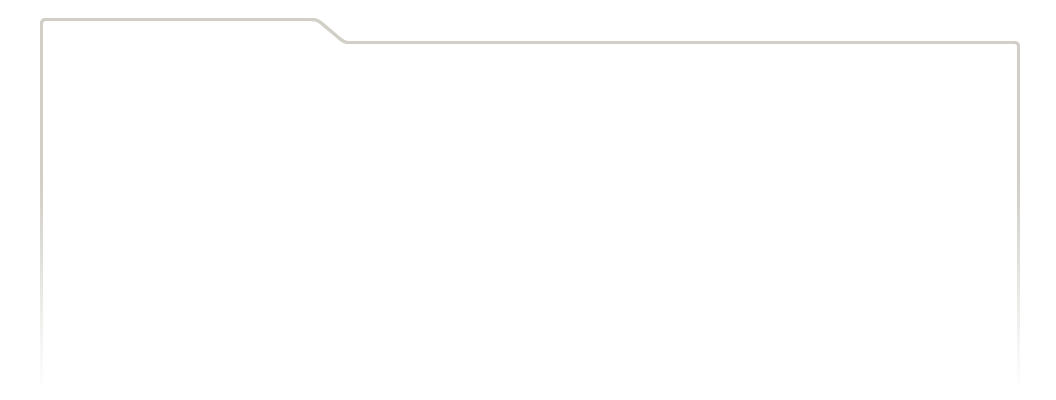
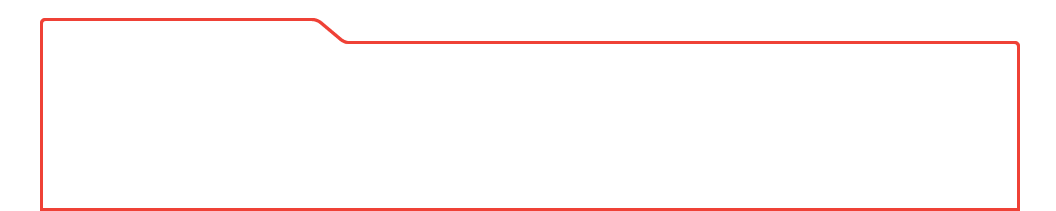
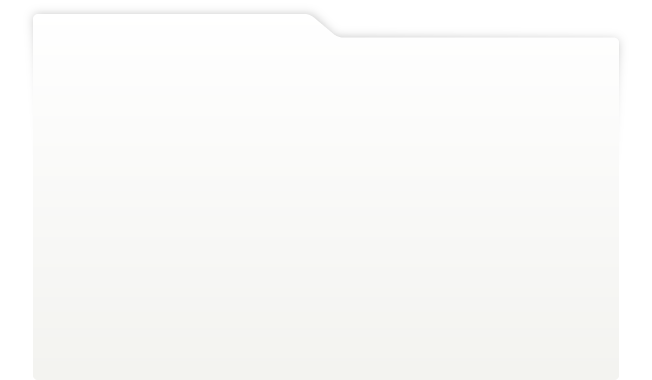
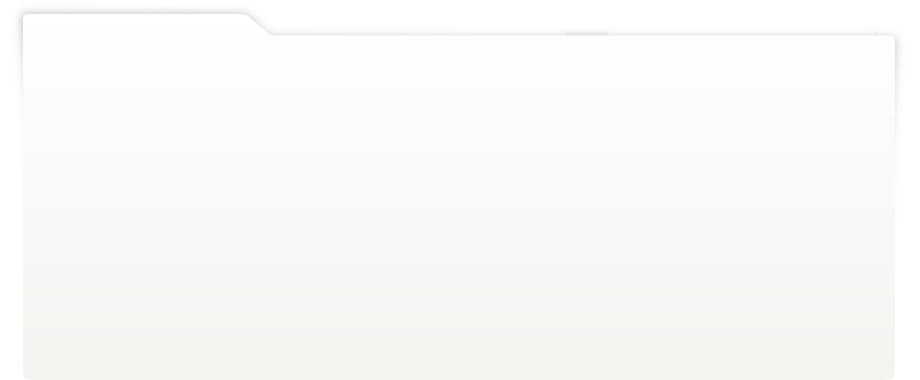
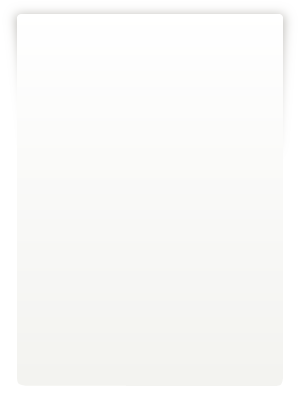
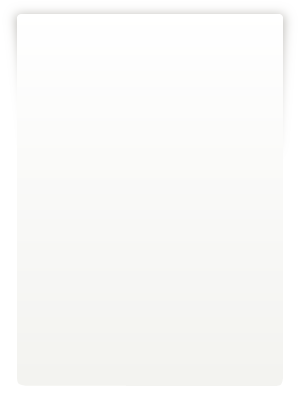
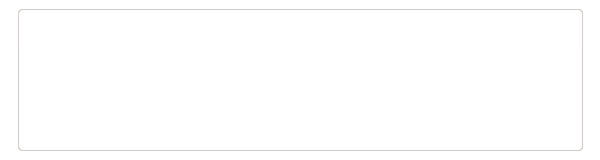
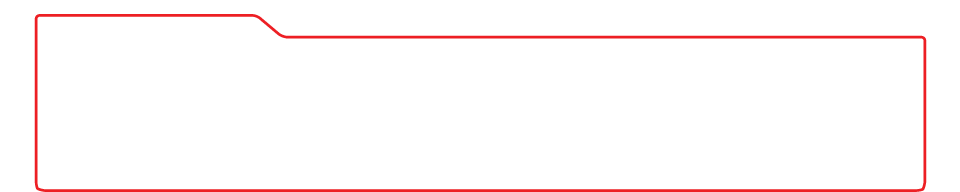
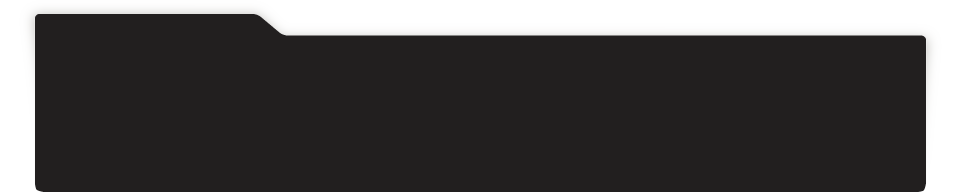
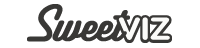
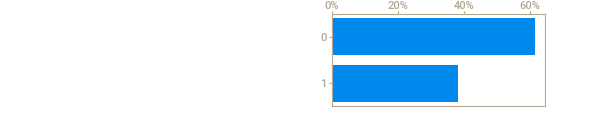
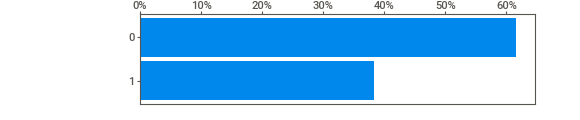
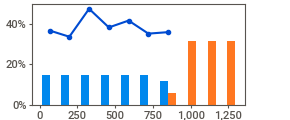
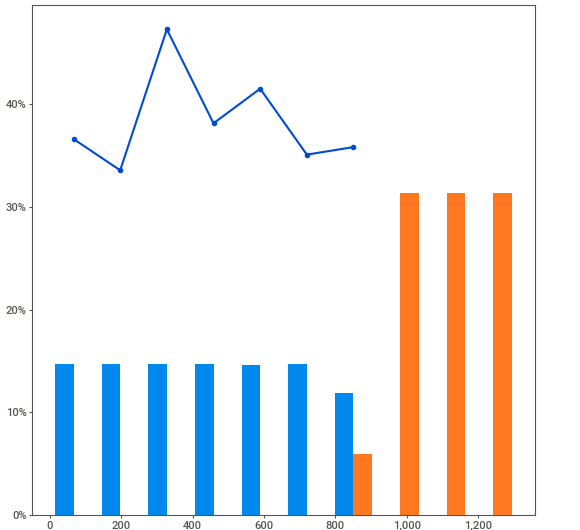
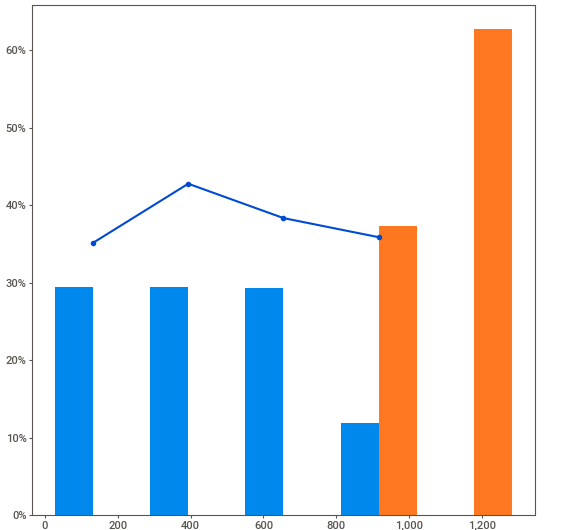
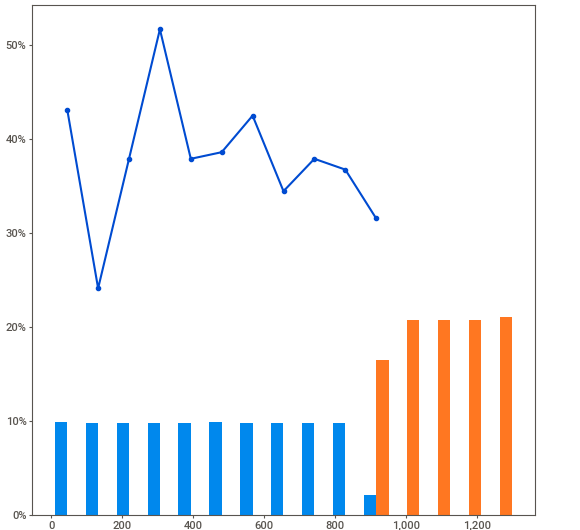
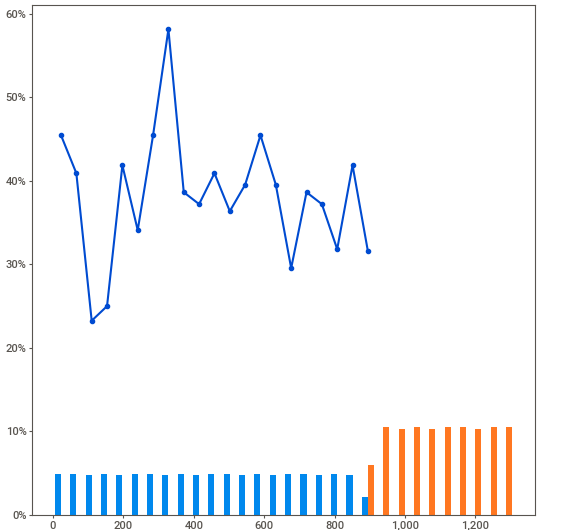
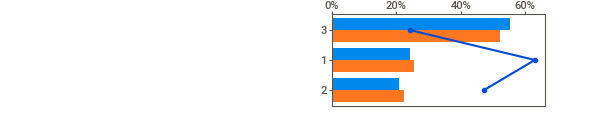
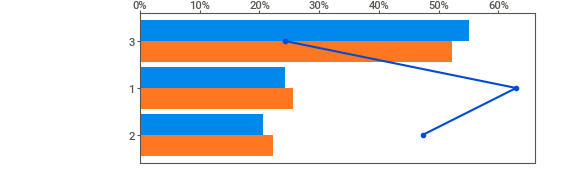
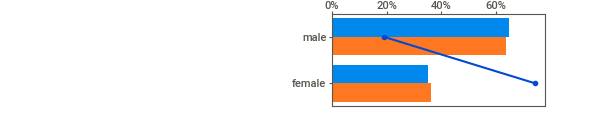
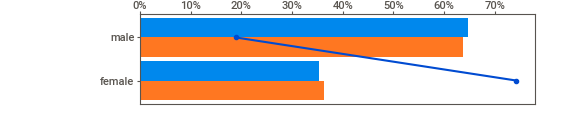
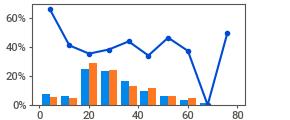
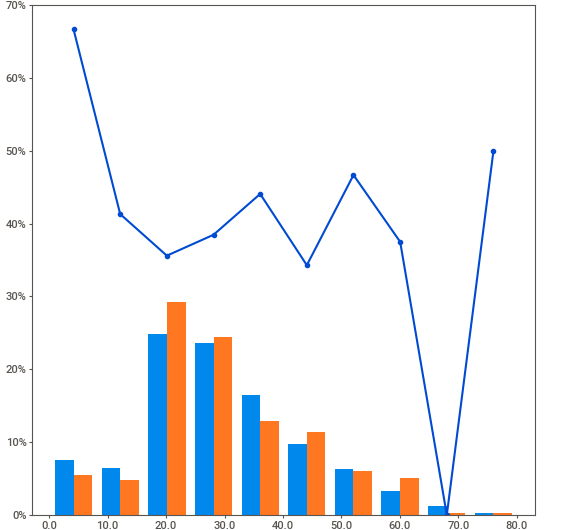
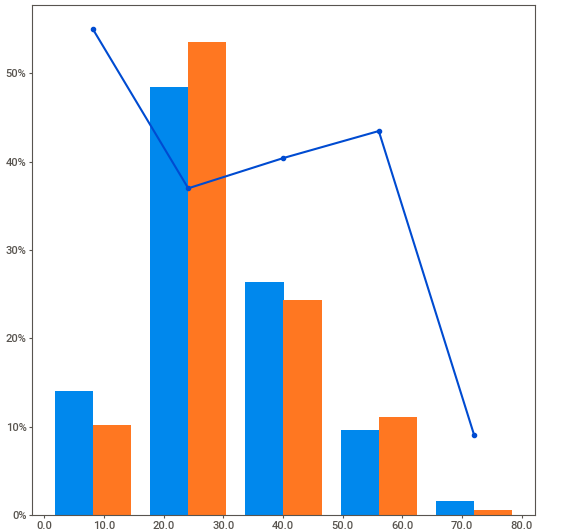
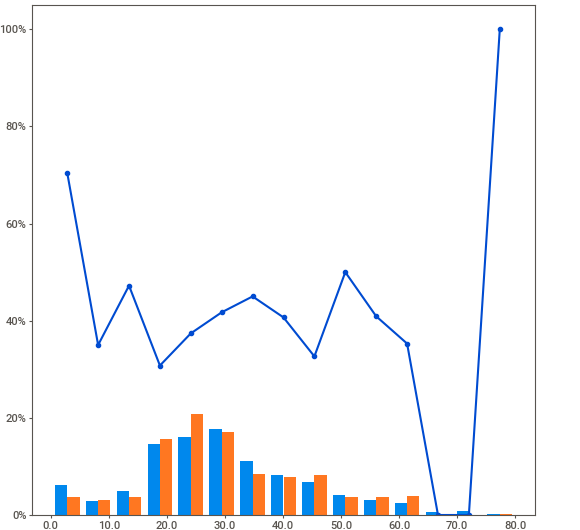
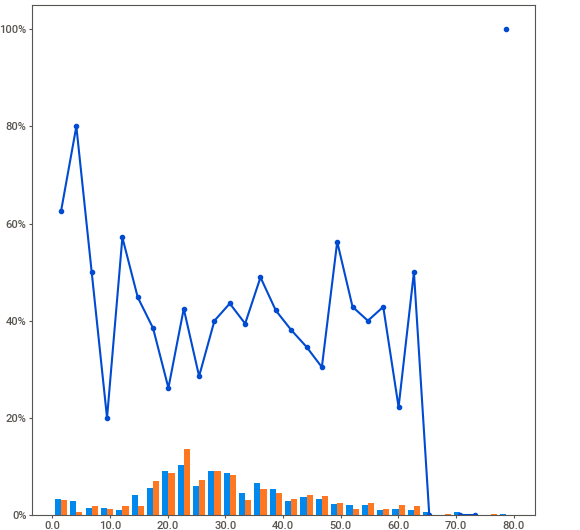
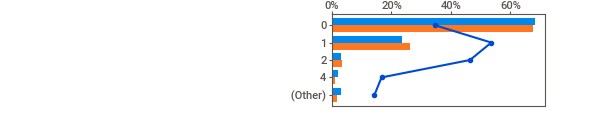
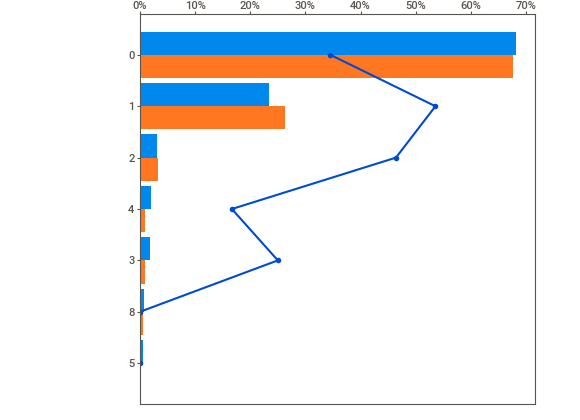
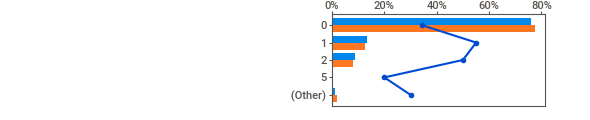
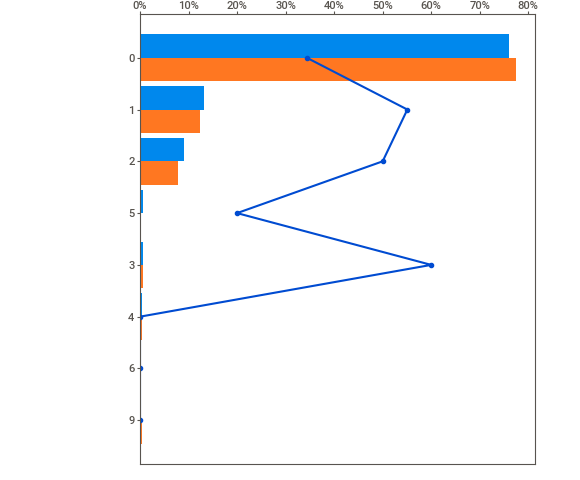
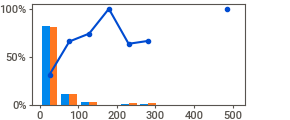
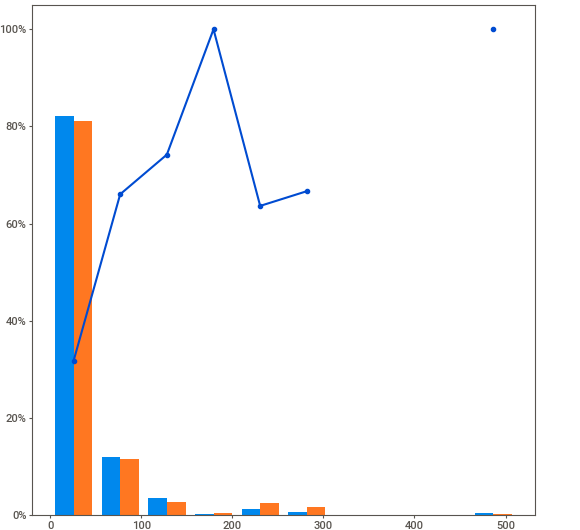
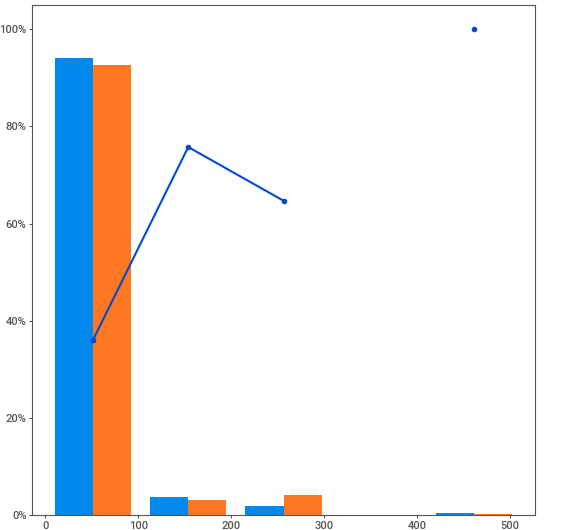
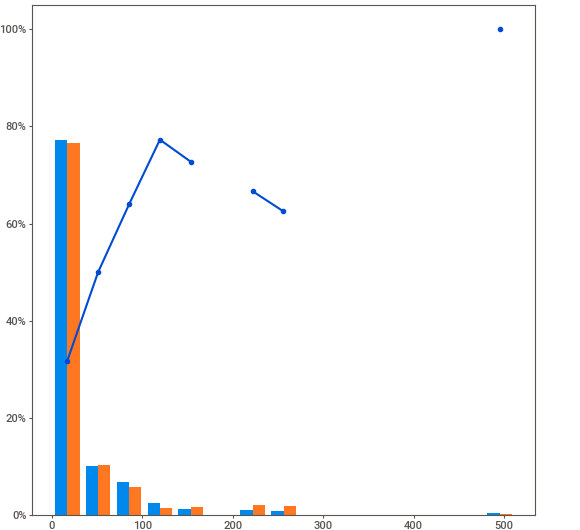
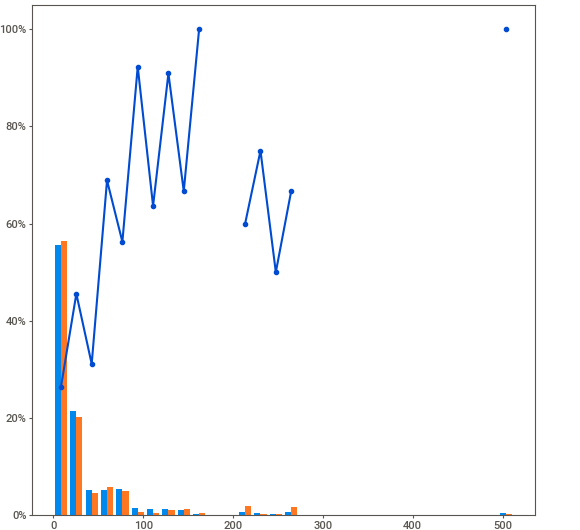
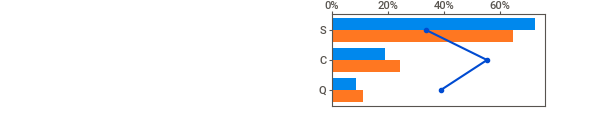
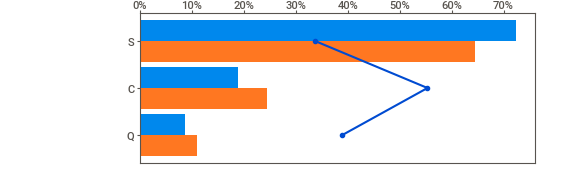
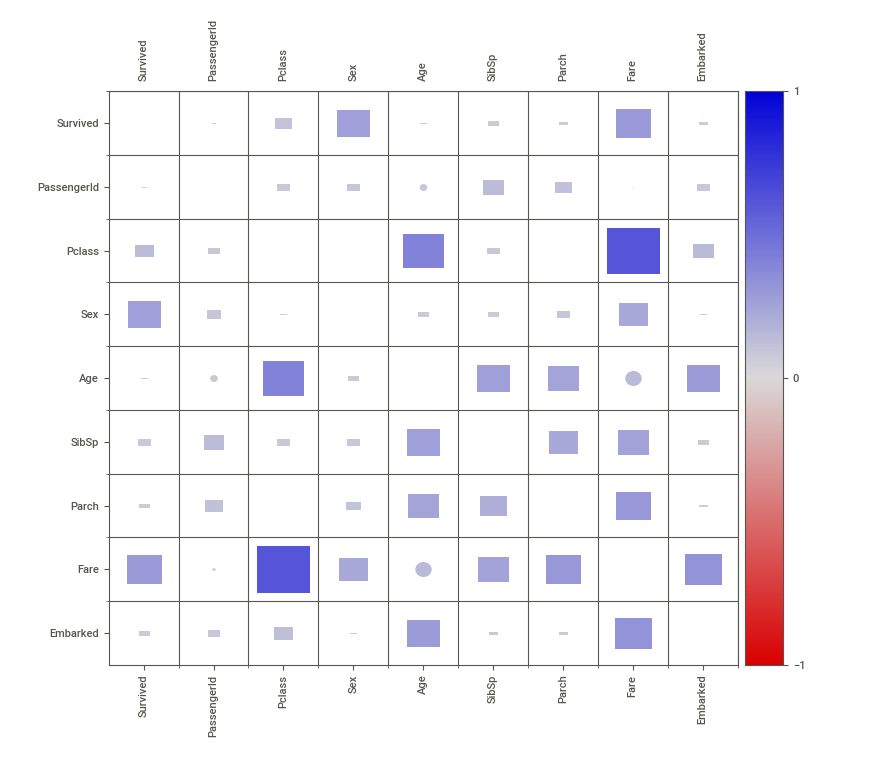
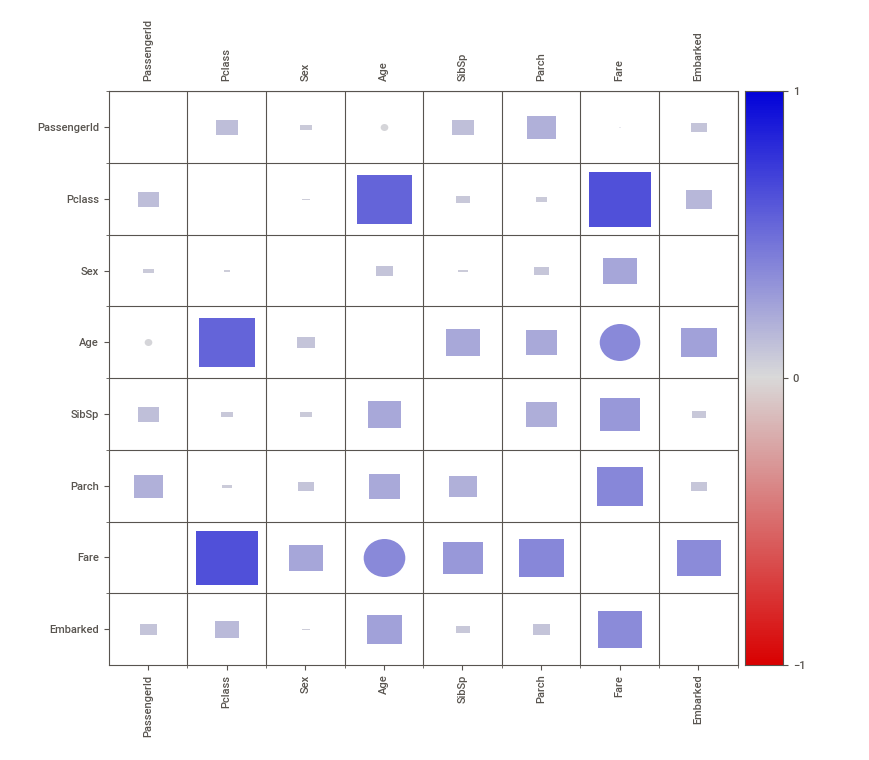

In [9]:
#my_report = sweetviz.analyze(train_df, "Survived")
my_report = sweetviz.compare([train_df, "Train"], [test_df, "Test"], "Survived")
my_report.show_notebook()

<a id ="3.2"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.2 Feature Selection</center></h2>

In [10]:
for column in train_df.columns:
    print(f"# of unique values in {column}: {train_df[column].nunique()}")

# of unique values in PassengerId: 891
# of unique values in Survived: 2
# of unique values in Pclass: 3
# of unique values in Name: 891
# of unique values in Sex: 2
# of unique values in Age: 88
# of unique values in SibSp: 7
# of unique values in Parch: 7
# of unique values in Ticket: 681
# of unique values in Fare: 248
# of unique values in Cabin: 147
# of unique values in Embarked: 3


In [11]:
target = 'Survived'
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked']
numerical_features = ['Age', 'Fare']

<a id ="3.3"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.3 Target Distribution</center></h2>

In [12]:
## Interactive Target Distribution Plot with plotly
target_count = train_df.groupby(target)['PassengerId'].count()
target_percent = target_count / target_count.sum()

## 1. Make Figure object
fig = go.Figure()

## 2. Make trace (graph object)
data = go.Bar(x=target_count.index.astype(str).values,
              y=target_count.values)

## 3. Add the trace to the Figure
fig.add_trace(data)

## 4. Setting layouts
fig.update_layout(title=dict(text='Target distribution'),
                  xaxis=dict(title='Survived values'),
                  yaxis=dict(title='counts'))

## 5. Show the Figure
fig.show()

<a id ="3.4"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.4 Numerical Features</center></h2>

In [13]:
## Statistics of training data
train_df[numerical_features].describe().T.style.bar(subset=['mean'],)\
                        .background_gradient(subset=['std'], cmap='coolwarm')\
                        .background_gradient(subset=['50%'], cmap='coolwarm')\
                        .background_gradient(subset=['max'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Age,714.000000,29.699118,14.526497,0.420000,20.125000,28.000000,38.000000,80.000000
Fare,891.000000,32.204208,49.693429,0.000000,7.910400,14.454200,31.000000,512.329200


In [14]:
## Statistics of test data
test_df[numerical_features].describe().T.style.bar(subset=['mean'],)\
                        .background_gradient(subset=['std'], cmap='coolwarm')\
                        .background_gradient(subset=['50%'], cmap='coolwarm')\
                        .background_gradient(subset=['max'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Age,332.000000,30.272590,14.181209,0.170000,21.000000,27.000000,39.000000,76.000000
Fare,417.000000,35.627188,55.907576,0.000000,7.895800,14.454200,31.500000,512.329200


In [15]:
## Interactive Heatmap of Correlation Matrix with plotly
train_numerical = train_df[numerical_features + ['Survived']]

fig = px.imshow(train_numerical.corr(),
                color_continuous_scale='RdBu_r',
                color_continuous_midpoint=0, 
                aspect='auto')
fig.update_layout(height=300, 
                  width=300,
                  title = "Heatmap",                  
                  showlegend=False)
fig.show()

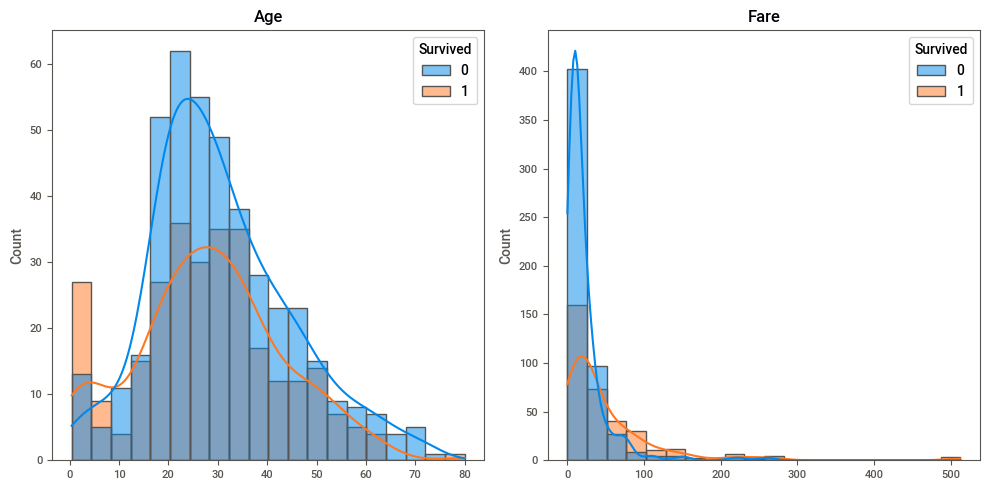

In [16]:
## Plotting distribution of numerical features with seaborn
bins = 20
fig = plt.figure(figsize=(10, 5))
for i, nf in enumerate(numerical_features):
    ax = fig.add_subplot(1, 2, i+1)
    sns.histplot(data=train_df,
                 x=nf,
                 bins=bins,
                 kde=True,
                 hue=target,
                 ax=ax)
    plt.title(nf)
    plt.xlabel(None)
fig.tight_layout()

In [17]:
## Fill NaN in numerical columns with its median
train_df[numerical_features] = train_df[numerical_features].fillna(train_df[numerical_features].median()) 
test_df[numerical_features] = test_df[numerical_features].fillna(train_df[numerical_features].median()) 

### Binning for Numerical Features

In [18]:
## Binning for "Age"
age_bins = np.array([i*5 for i in range(18)])
age_bins

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
       85])

In [19]:
## Binning for "Fare"
fare_mean = train_df['Fare'].mean()
print(f'fare mean: {fare_mean}\n')

fare_quantiles = train_df['Fare'].quantile([0, 0.05, 0.1, 0.5, 0.8, 0.9, 0.95, 0.99, 1])
print(f'fare quantiles: {fare_quantiles}\n')

fare_uniques = train_df['Fare'].unique()
fare_uniques.sort()
print(f'fare uniques: {fare_uniques}\n')

fare_bins = np.array([0, 10, 20, 30, 40, 50, 75, 100, 200, 500, 1_000])
print(f'fare_bins: {fare_bins}\n')

fare mean: 32.204207968574636

fare quantiles: 0.00      0.00000
0.05      7.22500
0.10      7.55000
0.50     14.45420
0.80     39.68750
0.90     77.95830
0.95    112.07915
0.99    249.00622
1.00    512.32920
Name: Fare, dtype: float64

fare uniques: [  0.       4.0125   5.       6.2375   6.4375   6.45     6.4958   6.75
   6.8583   6.95     6.975    7.0458   7.05     7.0542   7.125    7.1417
   7.225    7.2292   7.25     7.3125   7.4958   7.5208   7.55     7.6292
   7.65     7.725    7.7292   7.7333   7.7375   7.7417   7.75     7.775
   7.7875   7.7958   7.8      7.8292   7.8542   7.875    7.8792   7.8875
   7.8958   7.925    8.0292   8.05     8.1125   8.1375   8.1583   8.3
   8.3625   8.4042   8.4333   8.4583   8.5167   8.6542   8.6625   8.6833
   8.7125   8.85     9.       9.2167   9.225    9.35     9.475    9.4833
   9.5      9.5875   9.825    9.8375   9.8417   9.8458  10.1708  10.4625
  10.5     10.5167  11.1333  11.2417  11.5     12.      12.275   12.2875
  12.35    12.475   12.52

In [20]:
def binning(dataframe, column, bins):
    df = dataframe.copy()
    splits = pd.cut(df[column], 
                    bins=bins, 
                    labels=False, ## For return of integer index.
                    right=False)
    df[column] = splits
    return df

## Binning for numerical features
train = binning(train_df, 'Age', age_bins)
train = binning(train, 'Fare', fare_bins)

test = binning(test_df, 'Age', age_bins)
test = binning(test, 'Fare', fare_bins)

## After binning, 'Age' and 'Fare' become categorical features.
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked', 'Age', 'Fare']

<a id ="3.5"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.5 Categorical Features</center></h2>

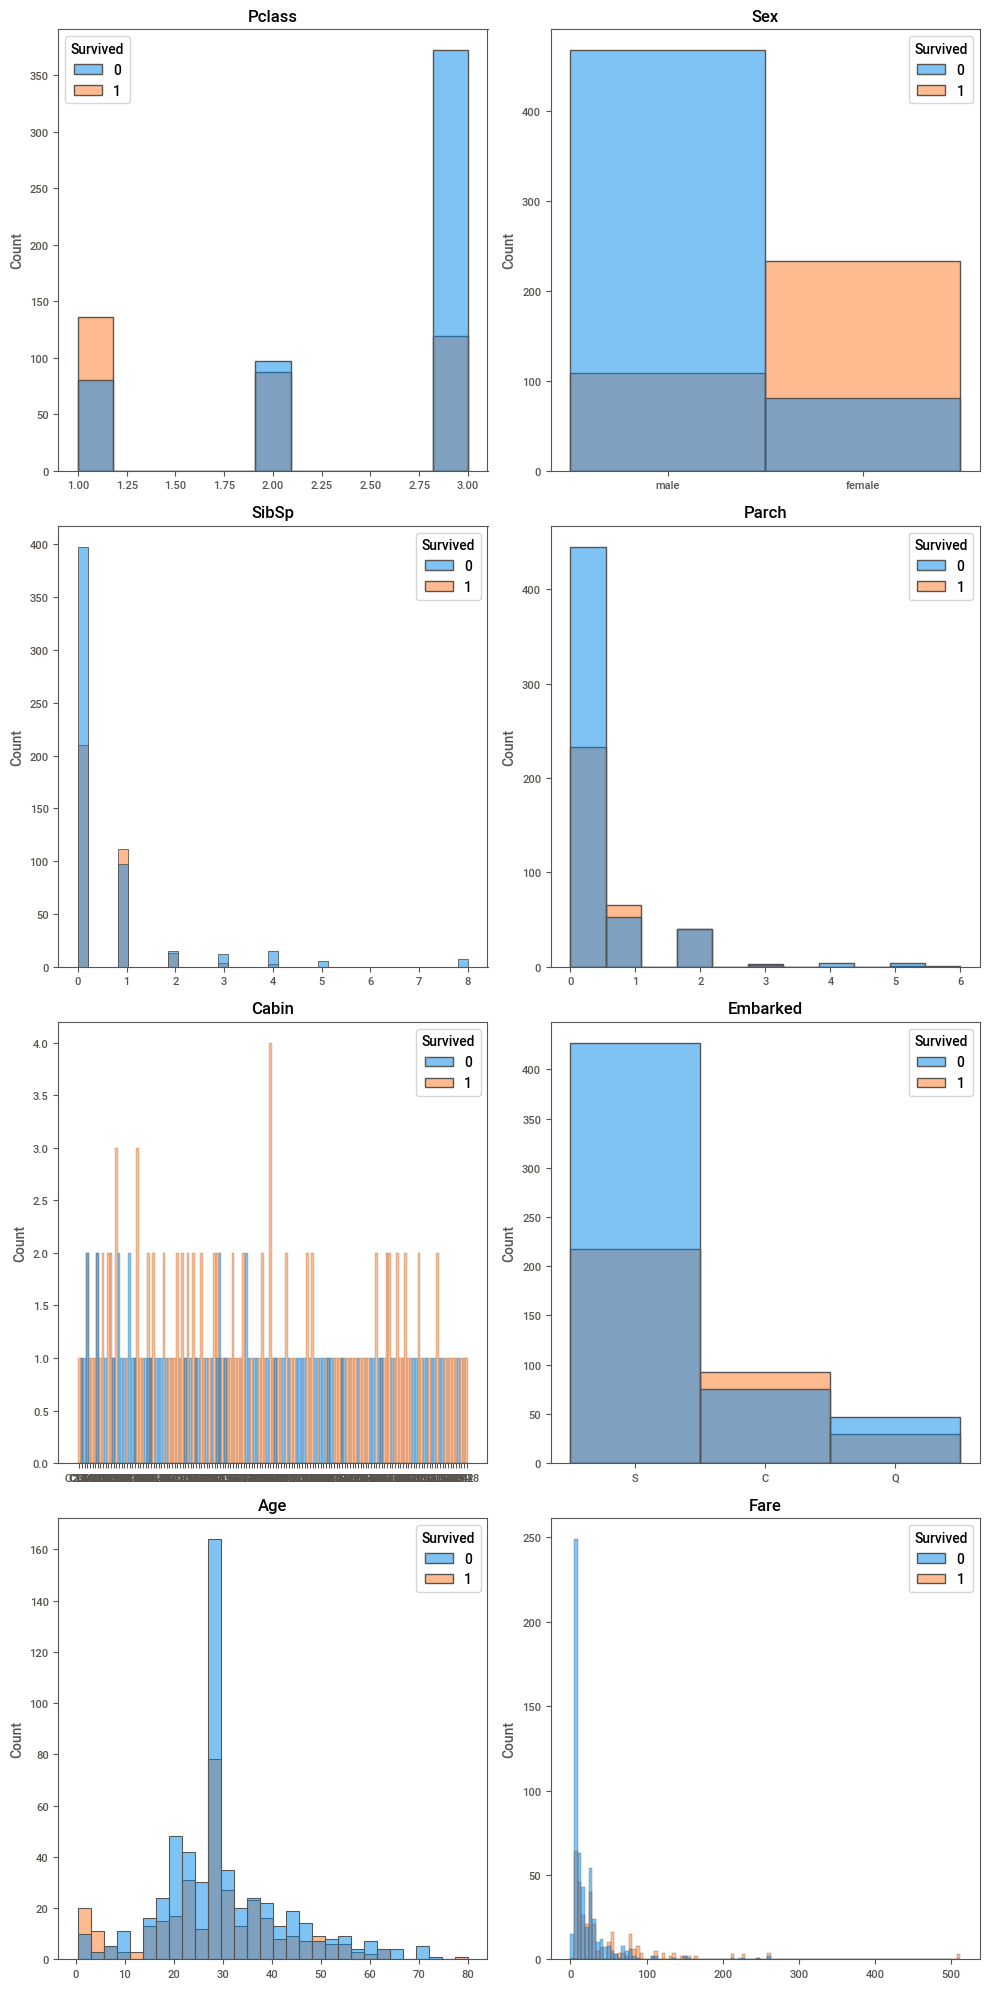

In [21]:
## Plotting distribution of categorical features with seaborn
fig = plt.figure(figsize=(10, 20))
for i, cf in enumerate(categorical_features):
    ax = fig.add_subplot(4, 2, i+1)
    sns.histplot(data=train_df,
                 x=cf,
                 hue=target,
                 kde=False,
                 ax=ax)
    plt.title(cf)
    plt.xlabel(None)
fig.tight_layout()

### Feature Engineering on 'Cabin'

In [22]:
train_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [23]:
def get_cabin_alphabet(cabin):
    if cabin is np.NaN:
        return 'NA'
    else:
        return cabin[0]
    
train['Cabin_alphabet'] = train['Cabin'].map(get_cabin_alphabet)
test['Cabin_alphabet'] = test['Cabin'].map(get_cabin_alphabet)

train = train.drop('Cabin', axis=1)
test = test.drop('Cabin', axis=1)

categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin_alphabet', 'Embarked', 'Age', 'Fare']

<AxesSubplot:xlabel='Cabin_alphabet', ylabel='Count'>

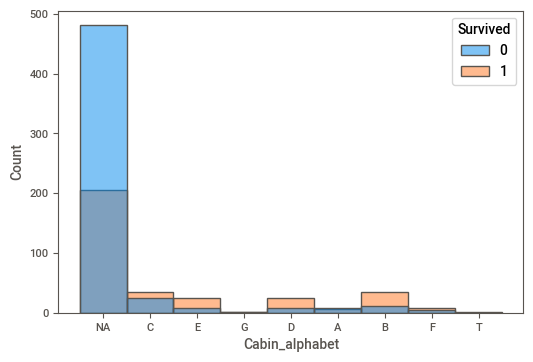

In [24]:
## Plotting distribution of 'Cabin_alphabet' with seaborn
sns.histplot(data=train,
             x='Cabin_alphabet',
             hue=target,
             kde=False)

### Data Encoding

In [25]:
## Fill NaN in categorical columns with its mode
train[categorical_features] = train[categorical_features].fillna(train[categorical_features].mode().iloc[0])  
test[categorical_features] = test[categorical_features].fillna(train[categorical_features].mode().iloc[0])  

In [26]:
def df_encode(categorical_features,
              train,
              test,
              valid=None,
              encoding='one_hot',
              encoder=None,
              return_encoder=False):
    
    if encoder is not None:
        enc = encoder
    else:
        if encoding == 'one_hot':
            enc = preprocessing.OneHotEncoder(handle_unknown='ignore',
                                              sparse=False,
                                              dtype=np.int32)
        elif encoding == 'label':
            enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',
                                               unknown_value=-1,
                                               dtype=np.int32)
        enc.fit(train[categorical_features])
        
    train_categorical = pd.DataFrame(enc.transform(train[categorical_features]),
                                     columns=enc.get_feature_names())
    test_categorical = pd.DataFrame(enc.transform(test[categorical_features]),
                                    columns=enc.get_feature_names())
    
    if valid is not None:
        valid_categorical = pd.DataFrame(enc.transform(valid[categorical_features]),
                                         columns=enc.get_feature_names())
        if return_encoder:
            return train_categorical, valid_categorical, test_categorical, enc
        else:
            return train_categorical, valid_categorical, test_categorical
        
    else:
        if return_encoder:
            return train_categorical, test_categorical, enc
        else:
            return train_categorical, test_categorical

In [27]:
## One-Hot Encoding
encoding = exp_config['encoding']

_, _, enc = df_encode(categorical_features,
                      train,
                      test,
                      encoding=encoding,
                      return_encoder=True)

train, test = df_encode(categorical_features,
                        train,
                        test,
                        encoding=encoding,
                        encoder=enc)

train[target] = train_df[target]
print(train.columns)
print(train.shape, test.shape)

Index(['x0_1', 'x0_2', 'x0_3', 'x1_female', 'x1_male', 'x2_0', 'x2_1', 'x2_2',
       'x2_3', 'x2_4', 'x2_5', 'x2_8', 'x3_0', 'x3_1', 'x3_2', 'x3_3', 'x3_4',
       'x3_5', 'x3_6', 'x4_A', 'x4_B', 'x4_C', 'x4_D', 'x4_E', 'x4_F', 'x4_G',
       'x4_NA', 'x4_T', 'x5_C', 'x5_Q', 'x5_S', 'x6_0', 'x6_1', 'x6_2', 'x6_3',
       'x6_4', 'x6_5', 'x6_6', 'x6_7', 'x6_8', 'x6_9', 'x6_10', 'x6_11',
       'x6_12', 'x6_13', 'x6_14', 'x6_16', 'x7_0', 'x7_1', 'x7_2', 'x7_3',
       'x7_4', 'x7_5', 'x7_6', 'x7_7', 'x7_8', 'x7_9', 'Survived'],
      dtype='object')
(891, 58) (418, 57)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



<a id ="3.6"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.6 Validation Split</center></h2>

In [28]:
## K-Fold validation split
n_splits = exp_config['n_splits']

#kf = KFold(n_splits=n_splits)
skf = StratifiedKFold(n_splits=n_splits)

train['k_folds'] = -1

#for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
for fold, (train_idx, valid_idx) in enumerate(skf.split(X=train,
                                                        y=train[target])):
    train['k_folds'][valid_idx] = fold
        
for i in range(n_splits):
    print(f"fold {i}: {len(train.query('k_folds==@i'))} samples")

fold 0: 179 samples
fold 1: 178 samples
fold 2: 178 samples
fold 3: 178 samples
fold 4: 178 samples


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
## Hold-out validation split
valid_fold = train.query('k_folds == 0').reset_index(drop=True)
train_fold = train.query('k_folds != 0').reset_index(drop=True)

train_fold = train_fold.drop(['k_folds'], axis=1)
valid_fold = valid_fold.drop(['k_folds'], axis=1)

print(len(train_fold), len(valid_fold))

712 179


<a id ="4"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>4. Deep Learning</center></h1>

<a id ="4.1"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>4.1 Creating Dataset</center></h2>

---
## [TPU] Batch size ##

To go fast on a TPU, increase the batch size. The rule of thumb is to use batches of 128 elements per core (ex: batch size of 128*8=1024 for a TPU with 8 cores). At this size, the 128x128 hardware matrix multipliers of the TPU (see hardware section below) are most likely to be kept busy. You start seeing interesting speedups from a batch size of 8 per core though. In the sample above, the batch size is scaled with the core count through this line of code:

In [30]:
if tpu:
    n_sample_per_TPU_core = exp_config['n_sample_per_TPU_core']
    batch_size = n_sample_per_TPU_core * strategy.num_replicas_in_sync
else:
    batch_size = exp_config['batch_size']

---

In [31]:
def df_to_dataset(data_frame,
                  target_column=None,
                  shuffle=False, repeat=False,
                  batch_size=5, drop_remainder=False):
    
    df = data_frame.copy()
    
    if target_column is not None:
        target = df.pop(target_column) ##PandasArray
        data = df.values
        ds = tf.data.Dataset.from_tensor_slices((data, target))
    else:
        data = df.values
        ds = tf.data.Dataset.from_tensor_slices(data)
        
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    if repeat:
        ds = ds.repeat()
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(batch_size)
    
    return ds

In [32]:
## Create datasets
batch_size = exp_config['batch_size']

train_ds = df_to_dataset(train_fold,
                         target_column=target,
                         shuffle=True,
                         repeat=False,
                         batch_size=batch_size,
                         drop_remainder=False,)
    
valid_ds = df_to_dataset(valid_fold,
                         target_column=target,
                         shuffle=False,
                         repeat=False,
                         batch_size=batch_size,
                         drop_remainder=False,)

f, t = next(iter(train_ds))
print(f.shape, t.shape)

(128, 57) (128,)


2022-06-26 07:47:18.658269: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<a id ="4.2"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>4.2 Creating Model</center></h2>

In [33]:
def create_training_model(input_shape, model_units=[128,], dropout_rates=[0.2]):
    
    model_inputs = layers.Input(shape=input_shape)
    x = model_inputs
    
    for units, dropout_rate in zip(model_units, dropout_rates):
        feedforward = keras.Sequential([
            layers.Dense(units, use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dropout(dropout_rate),
        ])
        x = feedforward(x)
        
    final_layer = layers.Dense(units=1, activation=None)
    model_outputs = final_layer(x)
    
    training_model = tf.keras.Model(inputs=model_inputs,
                                    outputs=model_outputs)
    return training_model

--- 
## [TPU] Model on TPUs ##

The strategy scope instructs Tensorflow to instantiate all the variables of the model in the memory of the TPU. The TPUClusterResolver.connect() call automatically enters the TPU device scope which instructs Tensorflow to run Tensorflow operations on the TPU. 

In [34]:
## Create training model
input_shape = model_config['model_input_shape']
model_units = model_config['model_units']
dropout_rates = model_config['dropout_rates']

if tpu:
    with strategy.scope():
        training_model = create_training_model(input_shape=input_shape,
                                               model_units=model_units, 
                                               dropout_rates=dropout_rates)
else:
    training_model = create_training_model(input_shape=input_shape,
                                           model_units=model_units, 
                                           dropout_rates=dropout_rates)

## Model compile and build
lr = exp_config['learning_rate']
label_smoothing = exp_config['label_smoothing']
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                             label_smoothing=label_smoothing)

training_model.compile(optimizer=optimizer,
                       loss=loss_fn,
                       metrics=['acc'])

training_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 57)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 64)                3904      
_________________________________________________________________
sequential_1 (Sequential)    (None, 48)                3264      
_________________________________________________________________
sequential_2 (Sequential)    (None, 32)                1664      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 8,865
Trainable params: 8,577
Non-trainable params: 288
_________________________________________________________________


---

<a id ="4.3"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>4.3 Training Model</center></h2>

---
## [TPU] Model saving/loading on TPUs ##
When loading and saving models TPU models from/to the local disk, the `experimental_io_device `option must be used. It can be omitted if writing to GCS because TPUs have direct access to GCS. This option does nothing on GPUs.

TPU users will remember that in order to train a model on TPU, you have to instantiate the model in a TPUStrategy scope. The strategy scope instructs Tensorflow to instantiate all the variables of the model in the memory of the TPU. The TPUClusterResolver.connect() call automatically enters the TPU device scope which instructs Tensorflow to run Tensorflow operations on the TPU. Now if you call model.save('./model') when you are connected to a TPU, Tensorflow will try to run the save operations on the TPU and since the TPU is a network-connected accelerator that has no access to your local disk, the operation will fail. Notice that saving to GCS will work though. The TPU does have access to GCS. If you want to save a TPU model to your local disk, you need to run the saving operation on your local machine and that is what the `experimental_io_device='/job:localhost'` flag does.

In [35]:
def model_training(training_model,
                   train_ds,
                   vali_ds,
                   epochs,
                   batch_size,
                   steps_per_epoch,
                   verbose=1,
                   fold=None,
                   model_save=True):
    
    ## For saving the best model
    checkpoint_filepath = exp_config['checkpoint_filepath'] ## './tmp/model/exp.ckpt'
    if fold is not None:
        l = checkpoint_filepath.split('/')  ## ['.', 'tmp', 'model', 'exp.ckpt']
        l[2] = l[2] + '_' + str(fold)
        checkpoint_filepath = '/'.join(l) ## f'./tmp/model_{fold}/exp.ckpt'
        
    if tpu:
        save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath, 
            save_weights_only=False, 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True,
            options=save_locally)  
    else:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath, 
            save_weights_only=True, 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)
        
    ## For the adjustment of learning rate
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        cooldown=10,
        min_lr=1e-5,
        verbose=verbose)
    
    if model_save:
        callbacks = [model_checkpoint_callback, reduce_lr]
    else:
        callbacks = [reduce_lr]
    
    ## Model training
    history = training_model.fit(train_ds,
                                 epochs=epochs,
                                 shuffle=True,
                                 validation_data=valid_ds,
                                 callbacks=callbacks,
                                 verbose=verbose,
                                 )
    
    ## Load the best parameters
    if model_save:
        if tpu:
            with strategy.scope():
                load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
                training_model = tf.keras.models.load_model(checkpoint_filepath,
                                                            options=load_locally)
        else:
            training_model.load_weights(checkpoint_filepath)
        
    return history

---

In [36]:
## Settings for Training
epochs = exp_config['train_epochs']
batch_size = exp_config['batch_size']
steps_per_epoch = len(train_ds)//batch_size 

history = model_training(training_model,
                         train_ds,
                         valid_ds,
                         epochs,
                         batch_size,
                         steps_per_epoch,
                         verbose=1,
                         fold=None)

Epoch 1/100


2022-06-26 07:47:21.101843: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


6/6 [==============================] - 2s 54ms/step - loss: 0.6283 - acc: 0.6966 - val_loss: 0.6731 - val_acc: 0.6145
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5682 - acc: 0.7303 - val_loss: 0.6632 - val_acc: 0.6145
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.5184 - acc: 0.7640 - val_loss: 0.6544 - val_acc: 0.6145
Epoch 4/100
6/6 [==============================] - 0s 6ms/step - loss: 0.4900 - acc: 0.7767 - val_loss: 0.6476 - val_acc: 0.6145
Epoch 5/100
6/6 [==============================] - 0s 6ms/step - loss: 0.4698 - acc: 0.7963 - val_loss: 0.6411 - val_acc: 0.6145
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 0.4496 - acc: 0.8174 - val_loss: 0.6350 - val_acc: 0.6145
Epoch 7/100
6/6 [==============================] - 0s 6ms/step - loss: 0.4365 - acc: 0.8160 - val_loss: 0.6294 - val_acc: 0.6145
Epoch 8/100
6/6 [==============================] - 0s 6ms/step - loss: 0.4219 - acc: 0.8258 - val_loss: 0.62

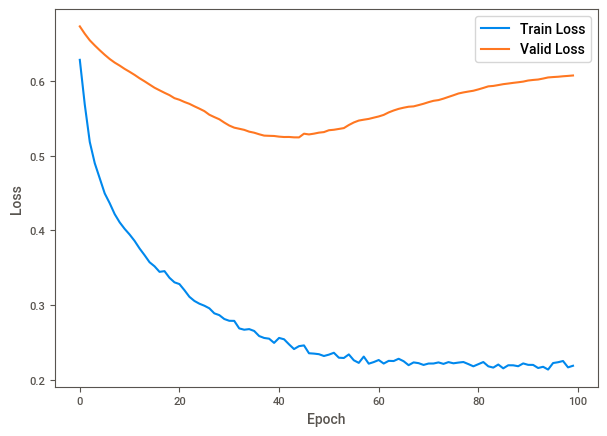

In [37]:
## Plot the train and valid losses
def plot_history(hist, title=None, valid=True):
    plt.figure(figsize=(7, 5))
    plt.plot(np.array(hist.index), hist['loss'], label='Train Loss')
    if valid:
        plt.plot(np.array(hist.index), hist['val_loss'], label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.show()
    
hist = pd.DataFrame(history.history)
plot_history(hist)

<a id ="4.4"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>4.4 Inference</center></h2>

In [38]:
## Create test dataset
test_ds = df_to_dataset(test,
                        target_column=None,
                        shuffle=False,
                        repeat=False,
                        batch_size=batch_size,
                        drop_remainder=False,)

f = next(iter(test_ds))
print(f.shape)

(128, 57)


In [39]:
logits = training_model.predict(test_ds)
probs = tf.math.sigmoid(logits)
probs = np.squeeze(probs)
preds = np.where(probs < 0.5, 0, 1)

submission_df[target] = preds

submission_df.to_csv('submission_dnn.csv', index=False)
submission_df.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


<a id ="5"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>5. Optimization</center></h1>

<img src="https://www.preferred.jp/wp-content/themes/preferred/assets/img/projects/optuna/pict01.jpg" width="200"/>

[Optuna™](https://www.preferred.jp/en/projects/optuna/) is an open-source automatic hyperparameter optimization framework. It automatically finds optimal hyperparameter values based on an optimization target.

In [40]:
def create_trial_model(trial):
    model = keras.Sequential()
    model.add(layers.Input(shape=model_config['model_input_shape']))
    
    activation = trial.suggest_categorical('activation', ['relu', 'gelu', 'selu'])
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        n_units = trial.suggest_discrete_uniform(f'units_{i}', 24, 256, 12)
        dropout_rate = trial.suggest_uniform(f'dropout_{i}', 0, 0.5)
        model.add(layers.Dense(n_units, use_bias=True, activation=activation))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(units=1, activation=None))
    
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    label_smoothing = trial.suggest_uniform('label_smoothing', 0, 0.2)
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                 label_smoothing=label_smoothing)
    model.compile(optimizer=optimizer,
                  loss=loss_fn,
                  metrics=['acc'])
    
    return model

In [41]:
def objective(trial):
    if tpu:
        with strategy.scope():
            compiled_model = create_trial_model(trial)
    else:
        compiled_model = create_trial_model(trial)
        
    epochs = opt_config['opt_epochs']
    batch_size = opt_config['opt_batch_size']
    steps_per_epoch = len(train_ds)//batch_size 
        
    history = model_training(compiled_model,
                             train_ds,
                             valid_ds,
                             epochs,
                             batch_size,
                             steps_per_epoch,
                             verbose=0,
                             fold=None,
                             model_save=False)
    
    return min(history.history['val_loss'])

In [42]:
if opt_config['opt_flg']:
    import optuna
    n_trials = opt_config['opt_trials']
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

[I 2022-06-26 07:47:29,915] A new study created in memory with name: no-name-67e353b3-e9f5-42b5-a7a2-d7f8df4db63a
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [24, 256] and q=12, but the range is not divisible by `q`. It will be replaced by [24, 252.0].

[I 2022-06-26 07:47:32,735] Trial 0 finished with value: 0.48091253638267517 and parameters: {'activation': 'relu', 'n_layers': 1, 'units_0': 132.0, 'dropout_0': 0.243768539082859, 'lr': 0.002471665641395357, 'label_smoothing': 0.020645350699772625}. Best is trial 0 with value: 0.48091253638267517.
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [24, 256] and q=12, but the range is not divisible by `q`. It will be replaced by [24, 252.0].

[I 2022-06-26 07:47:36,125] Trial 1 finished with value: 0.5897282361984253 and parameters: {'activation': 'relu', 'n_layers': 2, 'units_0': 192.0, 'dropout_0': 0.3

In [43]:
if opt_config['opt_flg']:
    best_params = study.best_params
    pprint.pprint(best_params)

{'activation': 'gelu',
 'dropout_0': 0.4023371754320621,
 'dropout_1': 0.10290155065360503,
 'label_smoothing': 0.0031384253957121673,
 'lr': 0.0013342397690882667,
 'n_layers': 2,
 'units_0': 216.0,
 'units_1': 216.0}


In [44]:
optuna.visualization.plot_optimization_history(study)

In [45]:
optuna.visualization.plot_slice(study)

<a id ="6"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>6. Cross Validation and Ensebmling</center></h1>

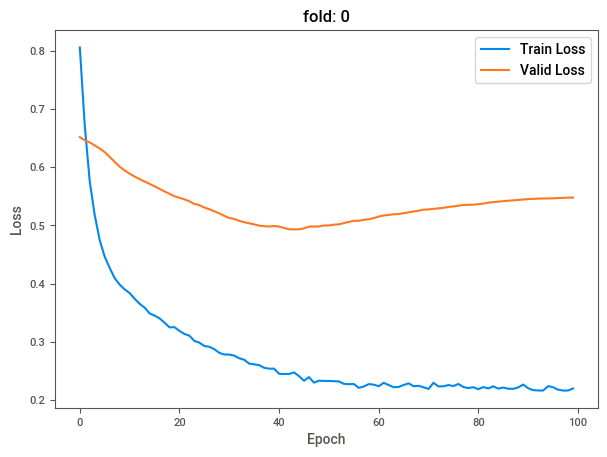

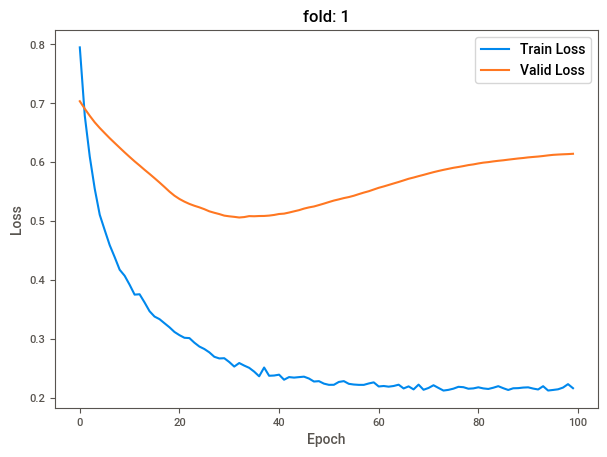

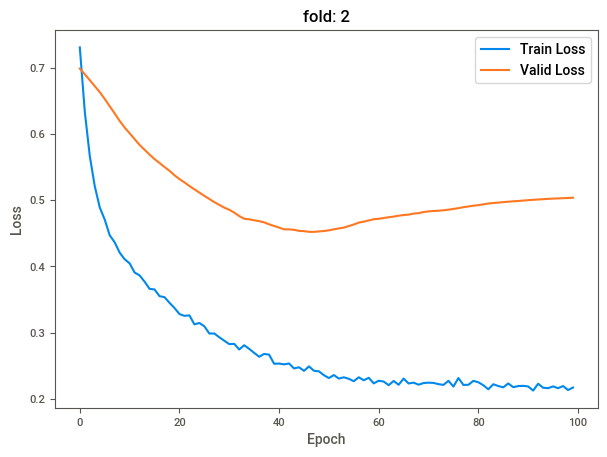

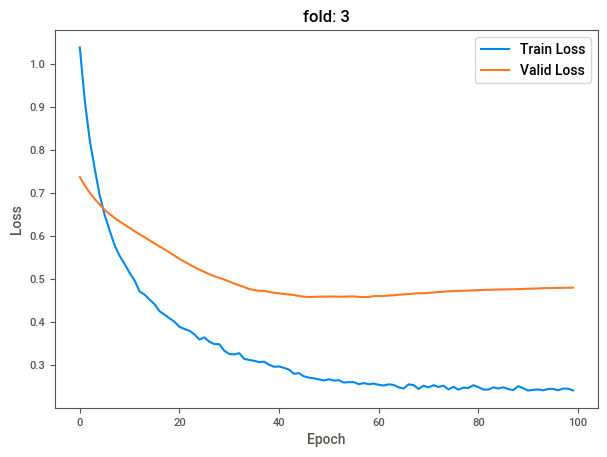

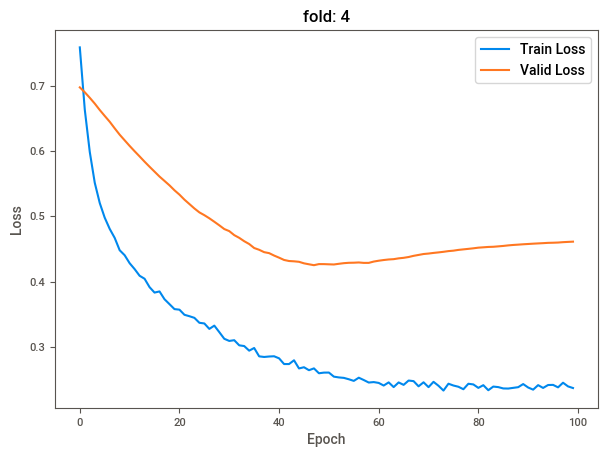

In [46]:
if exp_config['cross_validation']:
    ## Settings for Training
    batch_size = exp_config['batch_size']
    
    cv_results = submission_df.drop('Survived', axis=1)
    cv_results['probs_mean'] = 0.
    
    ## Create test dataset
    test_ds = df_to_dataset(test,
                            target_column=None,
                            shuffle=False,
                            repeat=False,
                            batch_size=batch_size,
                            drop_remainder=False,)
    
    ## Create cross validation samples
    for fold in range(exp_config['n_splits']):
        valid_fold = train.query(f'k_folds == {fold}').reset_index(drop=True)
        train_fold = train.query(f'k_folds != {fold}').reset_index(drop=True)
        
        train_fold = train_fold.drop(['k_folds'], axis=1)
        valid_fold = valid_fold.drop(['k_folds'], axis=1)
        
        ## Create datasets
        train_ds = df_to_dataset(train_fold,
                                 target_column=target,
                                 shuffle=True,
                                 repeat=False,
                                 batch_size=batch_size,
                                 drop_remainder=False,)
        
        valid_ds = df_to_dataset(valid_fold,
                                 target_column=target,
                                 shuffle=False,
                                 repeat=False,
                                 batch_size=batch_size,
                                 drop_remainder=False,)
        
        ## Create training model
        input_shape = model_config['model_input_shape']
        model_units = model_config['model_units']
        dropout_rates = model_config['dropout_rates']
        
        if tpu:
            with strategy.scope():
                training_model = create_training_model(input_shape=input_shape,
                                                       model_units=model_units, 
                                                       dropout_rates=dropout_rates)
        else:
            training_model = create_training_model(input_shape=input_shape,
                                                   model_units=model_units, 
                                                   dropout_rates=dropout_rates)
            
        ## Model compile and build
        lr = exp_config['learning_rate']
        label_smoothing = exp_config['label_smoothing']
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                     label_smoothing=label_smoothing)
        training_model.compile(optimizer=optimizer,
                               loss=loss_fn,
                               metrics=['acc'])
        
        ## Model training
        epochs = exp_config['train_epochs']
        batch_size = exp_config['batch_size']
        steps_per_epoch = len(train_ds)//batch_size 
        
        history = model_training(training_model,
                                 train_ds,
                                 valid_ds,
                                 epochs,
                                 batch_size,
                                 steps_per_epoch,
                                 verbose=0,
                                 fold=fold)
        
        ## Plot the train and valid losses
        hist = pd.DataFrame(history.history)
        plot_history(hist, title=f'fold: {fold}')
        
        ## Inference
        logits = training_model.predict(test_ds)
        probs = tf.math.sigmoid(logits)
        probs = np.squeeze(probs)
        cv_results[f'prods_{fold}'] = probs
        cv_results['probs_mean'] += probs
        
    ## Ensebmle the inferences of cross-validations
    cv_results['probs_mean'] /= exp_config['n_splits']
    probs_mean = cv_results['probs_mean'].values
    preds = np.where(probs_mean > 0.5, 1, 0)
    submission_df[target] = preds
    
    submission_df.to_csv('submission_cv.csv', index=False)

In [47]:
if exp_config['cross_validation']:
    submission_df.head(10)

In [48]:
if exp_config['cross_validation']:
    cv_results.head(10)

<a id ="7"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>7. AutoML</center></h1>

<img src="https://docs.h2o.ai/h2o/latest-stable/h2o-docs/_images/h2o-automl-logo.jpg" width="200"/>

AutoML (Automatic Machine Learning) is the process of automating algorithm selection, feature generation, hyperparameter tuning, iterative modeling, and model assessment. [H2O AutoML](https://h2o.ai/platform/h2o-automl/) can be used for automating the machine learning workflow with a simple interface in R, Python, or a web GUI.

<a id ="7.1"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>7.1 Set up</center></h2>

In [49]:
## Install and Import dependencies
#!pip install h2o -q
import h2o
from h2o.automl import H2OAutoML

## Initialize the H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.20.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.20.04.1, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp276v9k3_
  JVM stdout: /tmp/tmp276v9k3_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp276v9k3_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,2 months and 12 days
H2O_cluster_name:,H2O_from_python_unknownUser_71hfe8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.396 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


<a id ="7.2"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>7.2 Create Training Data</center></h2>

In [50]:
## Load the dataset as a H2OFrame
train_h2o_df = h2o.import_file(data_config['train.csv'])
test_h2o_df = h2o.import_file(data_config['test.csv'])

## How to make a H2OFrame from Pandas DataFrame
#train_h2o_df = h2o.H2OFrame(train)
#test_h2o_df = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [51]:
## Describe the dataset
train_h2o_df.describe(chunk_summary=False)

Rows:891
Cols:12




,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
type,int,int,int,string,enum,real,int,int,int,real,enum,enum
mins,1.0,0.0,1.0,NaN,,0.42,0.0,0.0,693.0,0.0,,
mean,446.0,0.3838383838383838,2.3086419753086447,NaN,,29.69911764705884,0.5230078563411893,0.3815937149270483,260318.5491679275,32.20420796857465,,
maxs,891.0,1.0,3.0,NaN,,80.0,8.0,6.0,3101298.0,512.3292,,
sigma,257.3538420152301,0.4865924542648575,0.8360712409770491,NaN,,14.526497332334035,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,,
zeros,0,549,0,0,,0,608,678,0,15,,
missing,0,0,0,0,0,177,0,0,230,0,687,2
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,nan,7.25,,S
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1.0,0.0,nan,71.2833,C85,C
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,nan,7.925,,S


For classification, target should be encoded as categorical (aka. "factor" or "enum"). As described, `Survived` column is encoded as a 0/1 "int", thus we have to convert the column as follows:

In [52]:
## Convert the column into categorical
train_h2o_df['Survived'] = train_h2o_df['Survived'].asfactor()
train_h2o_df.describe()

Rows:891
Cols:12




,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
type,int,enum,int,string,enum,real,int,int,int,real,enum,enum
mins,1.0,,1.0,NaN,,0.42,0.0,0.0,693.0,0.0,,
mean,446.0,,2.3086419753086447,NaN,,29.69911764705884,0.5230078563411893,0.3815937149270483,260318.5491679275,32.20420796857465,,
maxs,891.0,,3.0,NaN,,80.0,8.0,6.0,3101298.0,512.3292,,
sigma,257.3538420152301,,0.8360712409770491,NaN,,14.526497332334035,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,,
zeros,0,,0,0,,0,608,678,0,15,,
missing,0,0,0,0,0,177,0,0,230,0,687,2
0,1.0,0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,nan,7.25,,S
1,2.0,1,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1.0,0.0,nan,71.2833,C85,C
2,3.0,1,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,nan,7.925,,S


<a id ="7.3"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>7.3 Run AutoML</center></h2>

In [53]:
## Create AutoML Models
aml = H2OAutoML(max_models=10,
                exclude_algos=['GBM'],
                max_runtime_secs=120,
                balance_classes=True, ## This option is only applicable for classification.
                seed=42)

The `max_models` argument specifies the number of individual (or "base") models, and does not include the two ensemble models that are trained at the end. The current version of H2O AutoML trains and cross-validates the models in the following order:

1. three pre-specified XGBoost GBM (Gradient Boosting Machine) models,
2. a fixed grid of GLMs,
3. a default Random Forest (DRF),
4. five pre-specified H2O GBMs,
5. a near-default Deep Neural Net,
6. an Extremely Randomized Forest (XRT),
7. a random grid of XGBoost GBMs,
8. a random grid of H2O GBMs,
9. and a random grid of Deep Neural Nets.

In addition, it also trains the two ensemble models:

1. a stacked ensemble of all the models trained above
2. a “Best of Family” Stacked Ensemble that contains the best performing model for each algorithm class

**Nonte:** Particular algorithms (or groups of algorithms) can be switched on/off using the `include_algos` and`exclude_algos` argument.

In some cases, there will not be enough time to complete all the algorithms, so some may be missing from the leaderboard.

In [54]:
## Feature Selection
x = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Age', 'Fare']
y = 'Survived'

aml.train(training_frame=train_h2o_df,
          x=x, y=y)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_1_20220626_74957


Model Summary: 


,,number_of_trees
0,,36.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.08925188885586047
RMSE: 0.2987505462017776
LogLoss: 0.30169830033811584
Mean Per-Class Error: 0.1190441951874221
AUC: 0.9462339820407121
AUCPR: 0.9276996138729128
Gini: 0.8924679640814241

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5608727633953094: 


,,0,1,Error,Rate
0,0,513.0,36.0,0.0656,(36.0/549.0)
1,1,59.0,283.0,0.1725,(59.0/342.0)
2,Total,572.0,319.0,0.1066,(95.0/891.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.560873,0.856278,155.0
1,max f2,0.292746,0.881057,237.0
2,max f0point5,0.661832,0.894062,131.0
3,max accuracy,0.611060,0.894501,142.0
4,max precision,0.996696,1.000000,0.0
5,max recall,0.062191,1.000000,366.0
6,max specificity,0.996696,1.000000,0.0
7,max absolute_mcc,0.611060,0.775595,142.0
8,max min_per_class_accuracy,0.450936,0.871345,186.0
9,max mean_per_class_accuracy,0.560873,0.880956,155.0



Gains/Lift Table: Avg response rate: 38.38 %, avg score: 43.24 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010101,0.994866,2.605263,2.605263,1.000000,0.995961,1.000000,0.995961,0.026316,0.026316,160.526316,160.526316,0.026316
1,2,0.020202,0.993593,2.605263,2.605263,1.000000,0.994260,1.000000,0.995110,0.026316,0.052632,160.526316,160.526316,0.052632
2,3,0.030303,0.992377,2.605263,2.605263,1.000000,0.993037,1.000000,0.994419,0.026316,0.078947,160.526316,160.526316,0.078947
3,4,0.040404,0.989519,2.605263,2.605263,1.000000,0.991143,1.000000,0.993600,0.026316,0.105263,160.526316,160.526316,0.105263
4,5,0.050505,0.985133,2.605263,2.605263,1.000000,0.987347,1.000000,0.992349,0.026316,0.131579,160.526316,160.526316,0.131579
5,6,0.101010,0.971723,2.605263,2.605263,1.000000,0.978061,1.000000,0.985205,0.131579,0.263158,160.526316,160.526316,0.263158
6,7,0.150393,0.951752,2.486842,2.566379,0.954545,0.963357,0.985075,0.978031,0.122807,0.385965,148.684211,156.637863,0.382322
7,8,0.200898,0.899261,2.431579,2.532490,0.933333,0.925122,0.972067,0.964730,0.122807,0.508772,143.157895,153.249044,0.499664
8,9,0.300786,0.709698,2.195446,2.420562,0.842697,0.816220,0.929104,0.915412,0.219298,0.728070,119.544648,142.056167,0.693462
9,10,0.400673,0.462915,1.346541,2.152808,0.516854,0.580092,0.826331,0.831816,0.134503,0.862573,34.654051,115.280849,0.749640




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.13334456945461748
RMSE: 0.3651637570386983
LogLoss: 0.4305376163613901
Mean Per-Class Error: 0.18051960502348768
AUC: 0.8695874476720032
AUCPR: 0.8371329368485245
Gini: 0.7391748953440065

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5288487672805786: 


,,0,1,Error,Rate
0,0,476.0,73.0,0.133,(73.0/549.0)
1,1,78.0,264.0,0.2281,(78.0/342.0)
2,Total,554.0,337.0,0.1695,(151.0/891.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.528849,0.777614,171.0
1,max f2,0.193543,0.805613,287.0
2,max f0point5,0.684836,0.807114,128.0
3,max accuracy,0.684836,0.831650,128.0
4,max precision,0.994380,1.000000,0.0
5,max recall,0.031874,1.000000,389.0
6,max specificity,0.994380,1.000000,0.0
7,max absolute_mcc,0.528849,0.640772,171.0
8,max min_per_class_accuracy,0.395627,0.808743,201.0
9,max mean_per_class_accuracy,0.528849,0.819480,171.0



Gains/Lift Table: Avg response rate: 38.38 %, avg score: 43.08 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010101,0.990829,2.605263,2.605263,1.000000,0.993030,1.000000,0.993030,0.026316,0.026316,160.526316,160.526316,0.026316
1,2,0.020202,0.984843,2.605263,2.605263,1.000000,0.988379,1.000000,0.990704,0.026316,0.052632,160.526316,160.526316,0.052632
2,3,0.030303,0.981563,2.026316,2.412281,0.777778,0.983359,0.925926,0.988256,0.020468,0.073099,102.631579,141.228070,0.069456
3,4,0.040404,0.979214,2.605263,2.460526,1.000000,0.980369,0.944444,0.986284,0.026316,0.099415,160.526316,146.052632,0.095772
4,5,0.050505,0.977562,2.605263,2.489474,1.000000,0.978308,0.955556,0.984689,0.026316,0.125731,160.526316,148.947368,0.122088
5,6,0.102132,0.961567,2.378719,2.433488,0.913043,0.970494,0.934066,0.977513,0.122807,0.248538,137.871854,143.348757,0.237609
6,7,0.150393,0.933466,2.423501,2.430283,0.930233,0.949725,0.932836,0.968596,0.116959,0.365497,142.350061,143.028280,0.349104
7,8,0.200898,0.861509,2.489474,2.445163,0.955556,0.898543,0.938547,0.950985,0.125731,0.491228,148.947368,144.516319,0.471192
8,9,0.300786,0.699396,1.727085,2.206697,0.662921,0.778409,0.847015,0.893674,0.172515,0.663743,72.708457,120.669678,0.589061
9,10,0.400673,0.452188,1.229450,1.963069,0.471910,0.584095,0.753501,0.816496,0.122807,0.786550,22.945003,96.306944,0.626258




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.846212,0.030558,0.871508,0.853933,0.797753,0.870787,0.837079
1,auc,0.869404,0.036198,0.887719,0.886432,0.804813,0.886856,0.881199
2,err,0.153788,0.030558,0.128492,0.146067,0.202247,0.129213,0.162921
3,err_count,27.400000,5.412948,23.000000,26.000000,36.000000,23.000000,29.000000
4,f0point5,0.813809,0.043717,0.849359,0.830946,0.743671,0.845070,0.800000
5,f1,0.790072,0.040472,0.821705,0.816901,0.723077,0.806723,0.781955
6,f2,0.767825,0.039348,0.795796,0.803324,0.703593,0.771704,0.764706
7,lift_top_group,2.609863,0.122743,2.632353,2.438356,2.617647,2.781250,2.579710
8,logloss,0.430591,0.080429,0.383260,0.393879,0.572398,0.385745,0.417672
9,max_per_class_error,0.246254,0.039529,0.220588,0.205479,0.308824,0.250000,0.246377



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-06-26 07:50:03,1.448 sec,0.0,0.500000,0.693147,0.500000,0.383838,1.000000,0.616162
1,,2022-06-26 07:50:03,1.471 sec,5.0,0.366326,0.436372,0.902111,0.877455,2.605263,0.153760
2,,2022-06-26 07:50:03,1.495 sec,10.0,0.336170,0.373651,0.917756,0.895173,2.605263,0.130191
3,,2022-06-26 07:50:03,1.518 sec,15.0,0.325063,0.350082,0.924424,0.904778,2.605263,0.127946
4,,2022-06-26 07:50:03,1.547 sec,20.0,0.318113,0.335348,0.933031,0.914824,2.605263,0.122334
5,,2022-06-26 07:50:03,1.571 sec,25.0,0.311219,0.324013,0.938831,0.919097,2.605263,0.112233
6,,2022-06-26 07:50:03,1.610 sec,30.0,0.303921,0.312119,0.943102,0.923982,2.605263,0.109989
7,,2022-06-26 07:50:03,1.664 sec,35.0,0.299401,0.303050,0.946159,0.927086,2.605263,0.111111
8,,2022-06-26 07:50:03,1.688 sec,36.0,0.298751,0.301698,0.946234,0.927700,2.605263,0.106622



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Fare,447.412323,1.000000,0.313631
1,Sex.female,373.459930,0.834711,0.261791
2,Age,313.380615,0.700429,0.219676
3,Pclass,90.318550,0.201869,0.063312
4,Sex.male,68.402756,0.152885,0.047950
5,SibSp,50.544880,0.112972,0.035431
6,Parch,35.456554,0.079248,0.024855
7,Embarked.S,30.691525,0.068598,0.021514
8,Embarked.C,13.755078,0.030744,0.009642
9,Embarked.Q,3.134871,0.007007,0.002198


By default and when `nfolds` > 1, models will be evaluated using k-fold cross validation. Thus, when you would like to specify validation_frame for holdout validation, run the following codes:

In [55]:
#train_h2o, valid_h2o = train_h2o_df.split_frame(ratios=[0.8], seed=42)  ## Validation split
#aml = H2OAutoML(max_models=10,
#                exclude_algos=['GBM'],
#                max_runtime_secs=120,
#                balance_classes=True,
#                nfolds=0,
#                seed=42)
#aml.train(training_frame=train_h2o,
#          validation_frame=valid_h2o,
#          leaderboard_frame=valid_h2o,
#          x=x,　y=y,)

After the models are trained, we can compare the model performance using the leaderboard. When we did not specify a `leaderboard_frame` in the `H2OAutoML.train()` method, the AutoML leaderboard uses cross-validation metrics to score and rank the models.

In [56]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_2_AutoML_1_20220626_74957,0.869587,0.430538,0.837133,0.18052,0.365164,0.133345
XGBoost_3_AutoML_1_20220626_74957,0.868661,0.4358,0.84081,0.186703,0.367414,0.134993
StackedEnsemble_AllModels_1_AutoML_1_20220626_74957,0.868269,0.408956,0.851151,0.180807,0.354012,0.125324
StackedEnsemble_BestOfFamily_1_AutoML_1_20220626_74957,0.867526,0.413016,0.850544,0.182101,0.356466,0.127068
XGBoost_grid_1_AutoML_1_20220626_74957_model_2,0.867169,0.424582,0.847925,0.177524,0.358458,0.128492
DeepLearning_1_AutoML_1_20220626_74957,0.861798,0.428129,0.841169,0.198759,0.366346,0.134209
DeepLearning_grid_1_AutoML_1_20220626_74957_model_1,0.860853,0.456314,0.819577,0.190945,0.368703,0.135942
XRT_1_AutoML_1_20220626_74957,0.858773,0.44084,0.842191,0.183779,0.370012,0.136909
DRF_1_AutoML_1_20220626_74957,0.857159,0.472346,0.829997,0.18783,0.367806,0.135281
XGBoost_1_AutoML_1_20220626_74957,0.853982,0.453852,0.826593,0.187758,0.377092,0.142199


In the case of binary classification, the default ranking metric is Area Under the ROC Curve (AUC).

In [57]:
## Get the top model of leaderboard
best_model = aml.leader
#best_model = aml.get_best_model() ## same result

print(best_model)

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_1_20220626_74957


Model Summary: 


,,number_of_trees
0,,36.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.08925188885586047
RMSE: 0.2987505462017776
LogLoss: 0.30169830033811584
Mean Per-Class Error: 0.1190441951874221
AUC: 0.9462339820407121
AUCPR: 0.9276996138729128
Gini: 0.8924679640814241

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5608727633953094: 


,,0,1,Error,Rate
0,0,513.0,36.0,0.0656,(36.0/549.0)
1,1,59.0,283.0,0.1725,(59.0/342.0)
2,Total,572.0,319.0,0.1066,(95.0/891.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.560873,0.856278,155.0
1,max f2,0.292746,0.881057,237.0
2,max f0point5,0.661832,0.894062,131.0
3,max accuracy,0.611060,0.894501,142.0
4,max precision,0.996696,1.000000,0.0
5,max recall,0.062191,1.000000,366.0
6,max specificity,0.996696,1.000000,0.0
7,max absolute_mcc,0.611060,0.775595,142.0
8,max min_per_class_accuracy,0.450936,0.871345,186.0
9,max mean_per_class_accuracy,0.560873,0.880956,155.0



Gains/Lift Table: Avg response rate: 38.38 %, avg score: 43.24 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010101,0.994866,2.605263,2.605263,1.000000,0.995961,1.000000,0.995961,0.026316,0.026316,160.526316,160.526316,0.026316
1,2,0.020202,0.993593,2.605263,2.605263,1.000000,0.994260,1.000000,0.995110,0.026316,0.052632,160.526316,160.526316,0.052632
2,3,0.030303,0.992377,2.605263,2.605263,1.000000,0.993037,1.000000,0.994419,0.026316,0.078947,160.526316,160.526316,0.078947
3,4,0.040404,0.989519,2.605263,2.605263,1.000000,0.991143,1.000000,0.993600,0.026316,0.105263,160.526316,160.526316,0.105263
4,5,0.050505,0.985133,2.605263,2.605263,1.000000,0.987347,1.000000,0.992349,0.026316,0.131579,160.526316,160.526316,0.131579
5,6,0.101010,0.971723,2.605263,2.605263,1.000000,0.978061,1.000000,0.985205,0.131579,0.263158,160.526316,160.526316,0.263158
6,7,0.150393,0.951752,2.486842,2.566379,0.954545,0.963357,0.985075,0.978031,0.122807,0.385965,148.684211,156.637863,0.382322
7,8,0.200898,0.899261,2.431579,2.532490,0.933333,0.925122,0.972067,0.964730,0.122807,0.508772,143.157895,153.249044,0.499664
8,9,0.300786,0.709698,2.195446,2.420562,0.842697,0.816220,0.929104,0.915412,0.219298,0.728070,119.544648,142.056167,0.693462
9,10,0.400673,0.462915,1.346541,2.152808,0.516854,0.580092,0.826331,0.831816,0.134503,0.862573,34.654051,115.280849,0.749640




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.13334456945461748
RMSE: 0.3651637570386983
LogLoss: 0.4305376163613901
Mean Per-Class Error: 0.18051960502348768
AUC: 0.8695874476720032
AUCPR: 0.8371329368485245
Gini: 0.7391748953440065

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5288487672805786: 


,,0,1,Error,Rate
0,0,476.0,73.0,0.133,(73.0/549.0)
1,1,78.0,264.0,0.2281,(78.0/342.0)
2,Total,554.0,337.0,0.1695,(151.0/891.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.528849,0.777614,171.0
1,max f2,0.193543,0.805613,287.0
2,max f0point5,0.684836,0.807114,128.0
3,max accuracy,0.684836,0.831650,128.0
4,max precision,0.994380,1.000000,0.0
5,max recall,0.031874,1.000000,389.0
6,max specificity,0.994380,1.000000,0.0
7,max absolute_mcc,0.528849,0.640772,171.0
8,max min_per_class_accuracy,0.395627,0.808743,201.0
9,max mean_per_class_accuracy,0.528849,0.819480,171.0



Gains/Lift Table: Avg response rate: 38.38 %, avg score: 43.08 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010101,0.990829,2.605263,2.605263,1.000000,0.993030,1.000000,0.993030,0.026316,0.026316,160.526316,160.526316,0.026316
1,2,0.020202,0.984843,2.605263,2.605263,1.000000,0.988379,1.000000,0.990704,0.026316,0.052632,160.526316,160.526316,0.052632
2,3,0.030303,0.981563,2.026316,2.412281,0.777778,0.983359,0.925926,0.988256,0.020468,0.073099,102.631579,141.228070,0.069456
3,4,0.040404,0.979214,2.605263,2.460526,1.000000,0.980369,0.944444,0.986284,0.026316,0.099415,160.526316,146.052632,0.095772
4,5,0.050505,0.977562,2.605263,2.489474,1.000000,0.978308,0.955556,0.984689,0.026316,0.125731,160.526316,148.947368,0.122088
5,6,0.102132,0.961567,2.378719,2.433488,0.913043,0.970494,0.934066,0.977513,0.122807,0.248538,137.871854,143.348757,0.237609
6,7,0.150393,0.933466,2.423501,2.430283,0.930233,0.949725,0.932836,0.968596,0.116959,0.365497,142.350061,143.028280,0.349104
7,8,0.200898,0.861509,2.489474,2.445163,0.955556,0.898543,0.938547,0.950985,0.125731,0.491228,148.947368,144.516319,0.471192
8,9,0.300786,0.699396,1.727085,2.206697,0.662921,0.778409,0.847015,0.893674,0.172515,0.663743,72.708457,120.669678,0.589061
9,10,0.400673,0.452188,1.229450,1.963069,0.471910,0.584095,0.753501,0.816496,0.122807,0.786550,22.945003,96.306944,0.626258




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.846212,0.030558,0.871508,0.853933,0.797753,0.870787,0.837079
1,auc,0.869404,0.036198,0.887719,0.886432,0.804813,0.886856,0.881199
2,err,0.153788,0.030558,0.128492,0.146067,0.202247,0.129213,0.162921
3,err_count,27.400000,5.412948,23.000000,26.000000,36.000000,23.000000,29.000000
4,f0point5,0.813809,0.043717,0.849359,0.830946,0.743671,0.845070,0.800000
5,f1,0.790072,0.040472,0.821705,0.816901,0.723077,0.806723,0.781955
6,f2,0.767825,0.039348,0.795796,0.803324,0.703593,0.771704,0.764706
7,lift_top_group,2.609863,0.122743,2.632353,2.438356,2.617647,2.781250,2.579710
8,logloss,0.430591,0.080429,0.383260,0.393879,0.572398,0.385745,0.417672
9,max_per_class_error,0.246254,0.039529,0.220588,0.205479,0.308824,0.250000,0.246377



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-06-26 07:50:03,1.448 sec,0.0,0.500000,0.693147,0.500000,0.383838,1.000000,0.616162
1,,2022-06-26 07:50:03,1.471 sec,5.0,0.366326,0.436372,0.902111,0.877455,2.605263,0.153760
2,,2022-06-26 07:50:03,1.495 sec,10.0,0.336170,0.373651,0.917756,0.895173,2.605263,0.130191
3,,2022-06-26 07:50:03,1.518 sec,15.0,0.325063,0.350082,0.924424,0.904778,2.605263,0.127946
4,,2022-06-26 07:50:03,1.547 sec,20.0,0.318113,0.335348,0.933031,0.914824,2.605263,0.122334
5,,2022-06-26 07:50:03,1.571 sec,25.0,0.311219,0.324013,0.938831,0.919097,2.605263,0.112233
6,,2022-06-26 07:50:03,1.610 sec,30.0,0.303921,0.312119,0.943102,0.923982,2.605263,0.109989
7,,2022-06-26 07:50:03,1.664 sec,35.0,0.299401,0.303050,0.946159,0.927086,2.605263,0.111111
8,,2022-06-26 07:50:03,1.688 sec,36.0,0.298751,0.301698,0.946234,0.927700,2.605263,0.106622



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Fare,447.412323,1.000000,0.313631
1,Sex.female,373.459930,0.834711,0.261791
2,Age,313.380615,0.700429,0.219676
3,Pclass,90.318550,0.201869,0.063312
4,Sex.male,68.402756,0.152885,0.047950
5,SibSp,50.544880,0.112972,0.035431
6,Parch,35.456554,0.079248,0.024855
7,Embarked.S,30.691525,0.068598,0.021514
8,Embarked.C,13.755078,0.030744,0.009642
9,Embarked.Q,3.134871,0.007007,0.002198


In [58]:
## Save and load the model
model_path = h2o.save_model(model=best_model,
                            path='./automl_model', 
                            force=True)
print(model_path)
loaded_model = h2o.load_model(path=model_path)

/kaggle/working/automl_model/XGBoost_2_AutoML_1_20220626_74957


In [59]:
## Inference
probs = aml.predict(test_h2o_df)
#probs = best_model.predict(test_h2o_df) ## same result

probs = h2o.as_list(probs) ## Convert to pandas DataFrame
preds = probs['predict'].values
submission_df[target] = preds

submission_df.to_csv('submission_automl.csv', index=False)
submission_df.head(20)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


<a id ="7.4"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>7.4 Explainability</center></h2>

H2O AutoML provides insights into model’s global explainability (such as variable importance, partial dependence plot, SHAP values, and model correlation) and local explainability for individual records.

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
XGBoost_2_AutoML_1_20220626_74957,0.869587,0.430538,0.837133,0.18052,0.365164,0.133345,267,0.013628,XGBoost
XGBoost_3_AutoML_1_20220626_74957,0.868661,0.4358,0.84081,0.186703,0.367414,0.134993,3266,0.015801,XGBoost
StackedEnsemble_AllModels_1_AutoML_1_20220626_74957,0.868269,0.408956,0.851151,0.180807,0.354012,0.125324,2090,0.061828,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20220626_74957,0.867526,0.413016,0.850544,0.182101,0.356466,0.127068,2310,0.061827,StackedEnsemble
XGBoost_grid_1_AutoML_1_20220626_74957_model_2,0.867169,0.424582,0.847925,0.177524,0.358458,0.128492,275,0.010166,XGBoost
DeepLearning_1_AutoML_1_20220626_74957,0.861798,0.428129,0.841169,0.198759,0.366346,0.134209,187,0.015545,DeepLearning
DeepLearning_grid_1_AutoML_1_20220626_74957_model_1,0.860853,0.456314,0.819577,0.190945,0.368703,0.135942,17331,0.01151,DeepLearning
XRT_1_AutoML_1_20220626_74957,0.858773,0.44084,0.842191,0.183779,0.370012,0.136909,428,0.038434,DRF
DRF_1_AutoML_1_20220626_74957,0.857159,0.472346,0.829997,0.18783,0.367806,0.135281,669,0.042102,DRF
XGBoost_1_AutoML_1_20220626_74957,0.853982,0.453852,0.826593,0.187758,0.377092,0.142199,291,0.01044,XGBoost


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_2_AutoML_1_20220626_74957


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5608727633953094: 


,,0,1,Error,Rate
0,0,513.0,36.0,0.0656,(36.0/549.0)
1,1,59.0,283.0,0.1725,(59.0/342.0)
2,Total,572.0,319.0,0.1066,(95.0/891.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

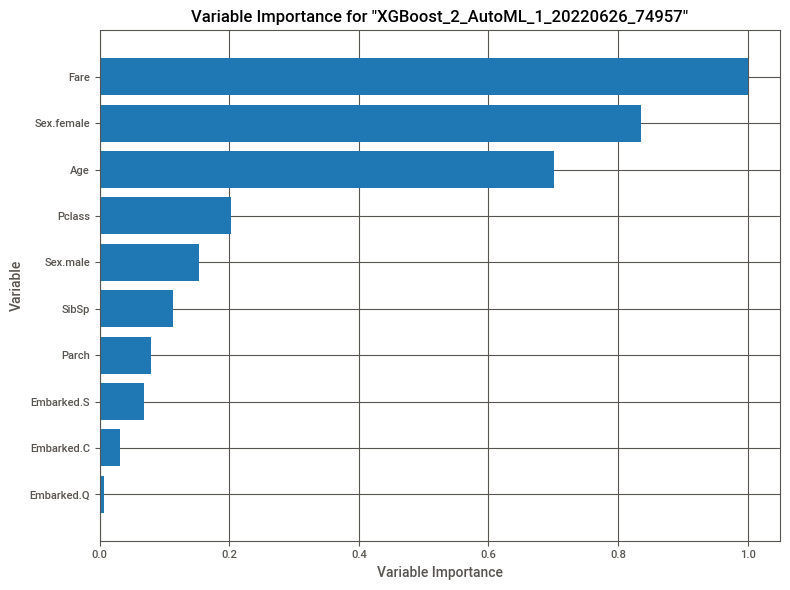

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

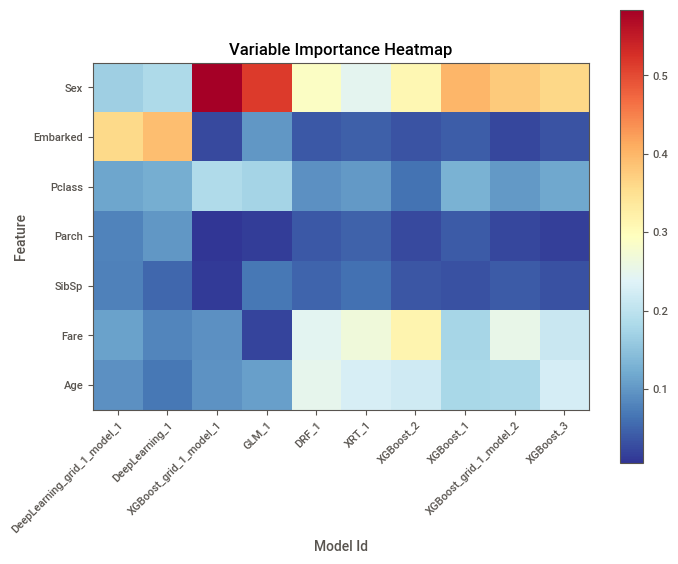

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

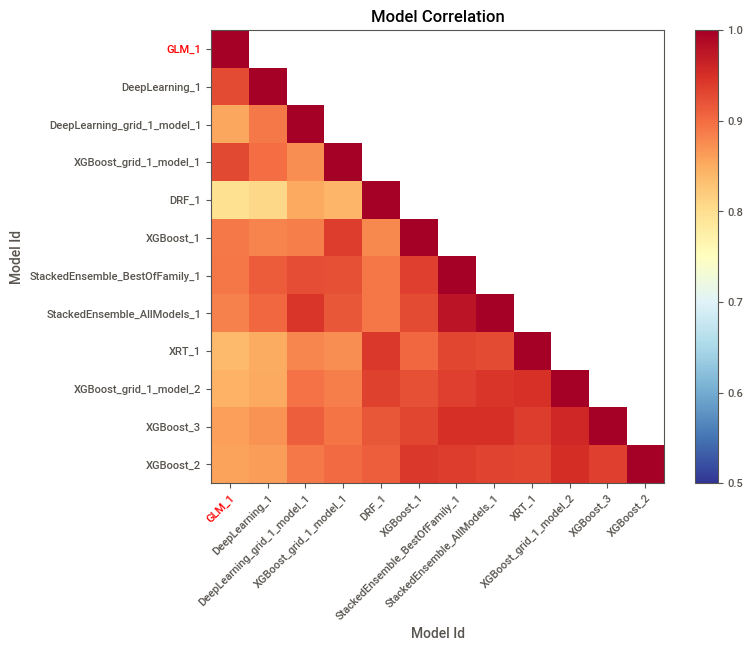

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

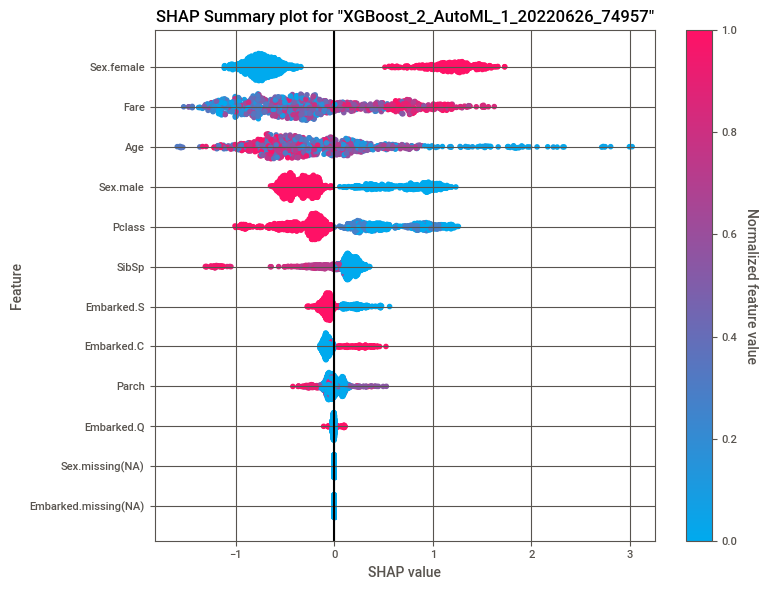

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

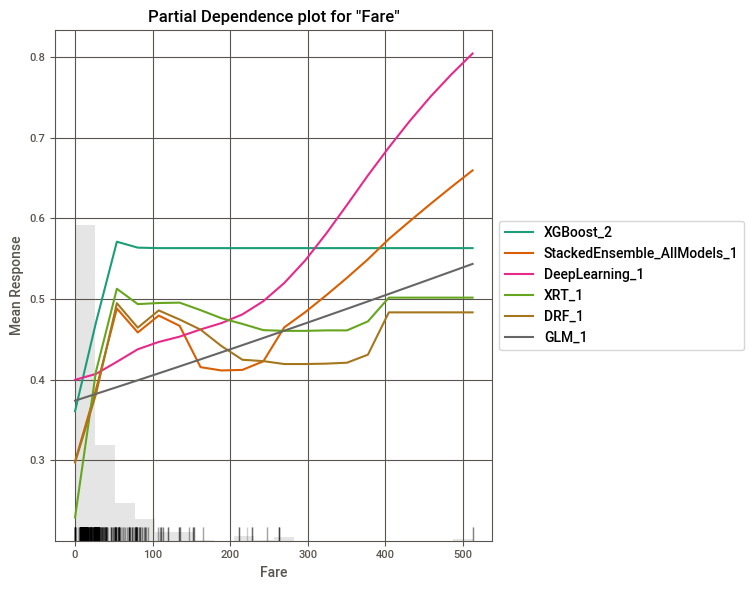

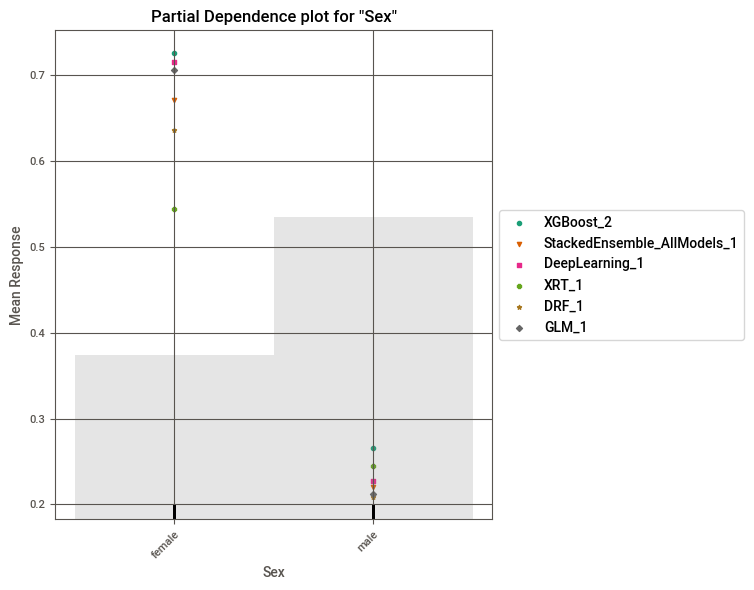

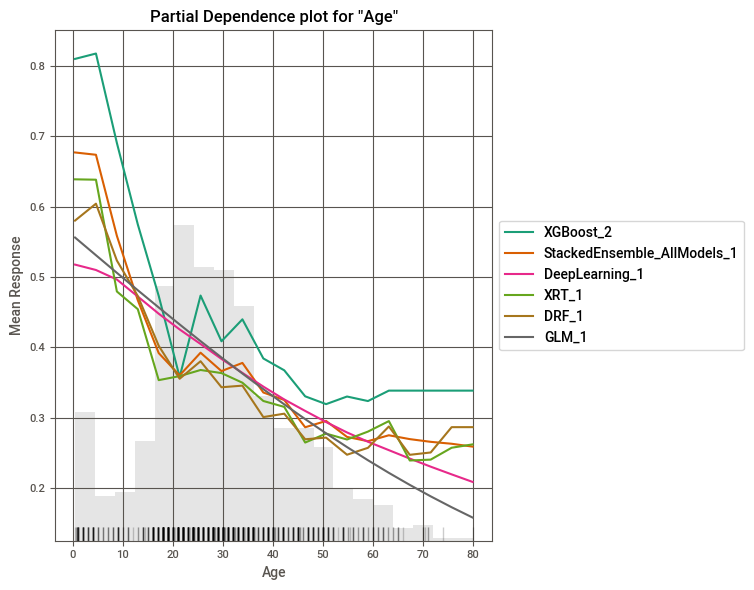

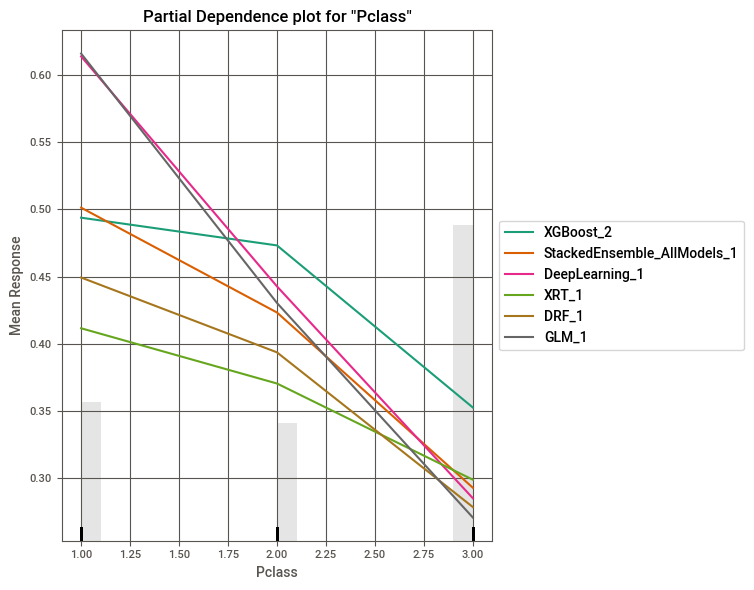

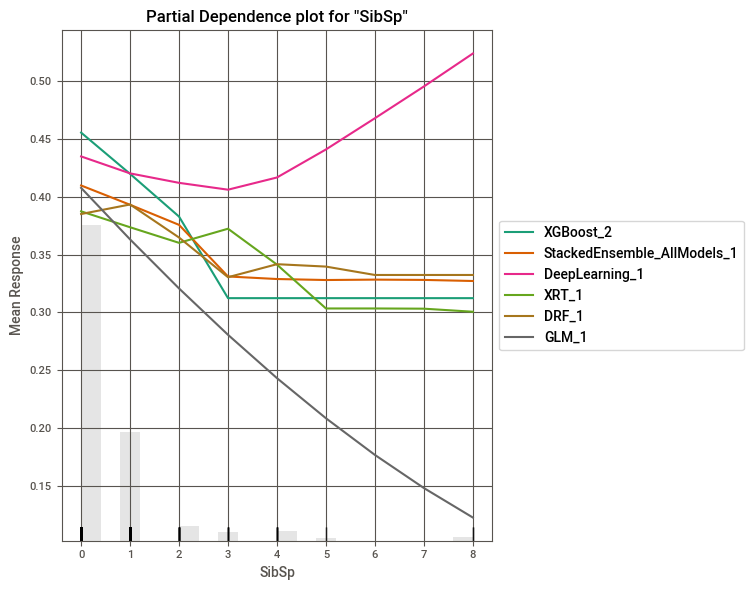

In [60]:
## Global explainability for models
explain_model = aml.explain(frame=train_h2o_df, figsize=(8, 6))

# Leaderboard

> Leaderboard shows models with their metrics and their predictions for a given row. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo,predict,p0,p1
XGBoost_2_AutoML_1_20220626_74957,0.869587,0.430538,0.837133,0.18052,0.365164,0.133345,267,0.013628,XGBoost,1,0.0064491,0.993551
XGBoost_3_AutoML_1_20220626_74957,0.868661,0.4358,0.84081,0.186703,0.367414,0.134993,3266,0.015801,XGBoost,1,0.00397903,0.996021
StackedEnsemble_AllModels_1_AutoML_1_20220626_74957,0.868269,0.408956,0.851151,0.180807,0.354012,0.125324,2090,0.061828,StackedEnsemble,1,0.00870795,0.991292
StackedEnsemble_BestOfFamily_1_AutoML_1_20220626_74957,0.867526,0.413016,0.850544,0.182101,0.356466,0.127068,2310,0.061827,StackedEnsemble,1,0.0043543,0.995646
XGBoost_grid_1_AutoML_1_20220626_74957_model_2,0.867169,0.424582,0.847925,0.177524,0.358458,0.128492,275,0.010166,XGBoost,1,0.00780028,0.9922
DeepLearning_1_AutoML_1_20220626_74957,0.861798,0.428129,0.841169,0.198759,0.366346,0.134209,187,0.015545,DeepLearning,1,0.0307657,0.969234
DeepLearning_grid_1_AutoML_1_20220626_74957_model_1,0.860853,0.456314,0.819577,0.190945,0.368703,0.135942,17331,0.01151,DeepLearning,1,0.00362194,0.996378
XRT_1_AutoML_1_20220626_74957,0.858773,0.44084,0.842191,0.183779,0.370012,0.136909,428,0.038434,DRF,1,0.0378041,0.962196
DRF_1_AutoML_1_20220626_74957,0.857159,0.472346,0.829997,0.18783,0.367806,0.135281,669,0.042102,DRF,1,0,1
XGBoost_1_AutoML_1_20220626_74957,0.853982,0.453852,0.826593,0.187758,0.377092,0.142199,291,0.01044,XGBoost,1,0.0291141,0.970886


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

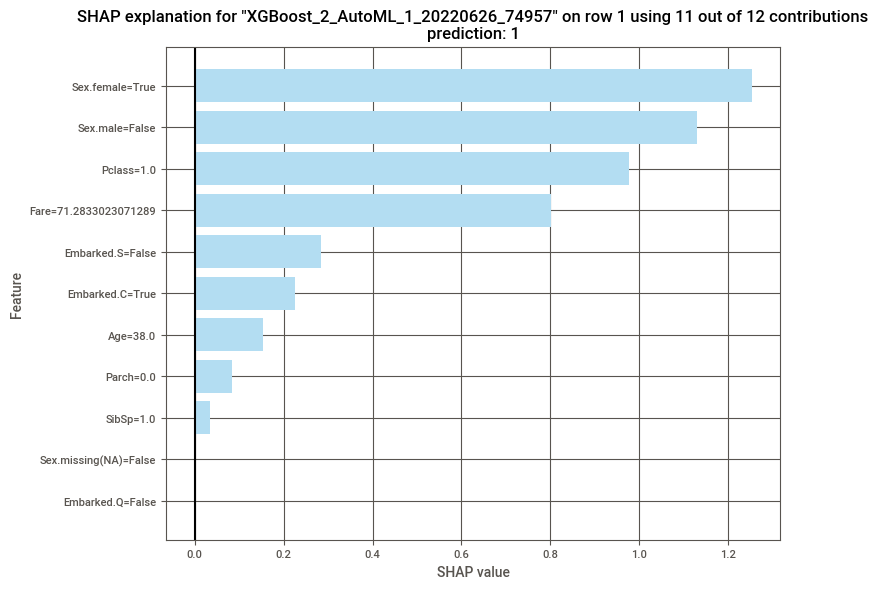

# Leaderboard

> Leaderboard shows models with their metrics and their predictions for a given row. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo,predict,p0,p1
XGBoost_2_AutoML_1_20220626_74957,0.869587,0.430538,0.837133,0.18052,0.365164,0.133345,267,0.013628,XGBoost,1,0.0064491,0.993551
XGBoost_3_AutoML_1_20220626_74957,0.868661,0.4358,0.84081,0.186703,0.367414,0.134993,3266,0.015801,XGBoost,1,0.00397903,0.996021
StackedEnsemble_AllModels_1_AutoML_1_20220626_74957,0.868269,0.408956,0.851151,0.180807,0.354012,0.125324,2090,0.061828,StackedEnsemble,1,0.00870795,0.991292
StackedEnsemble_BestOfFamily_1_AutoML_1_20220626_74957,0.867526,0.413016,0.850544,0.182101,0.356466,0.127068,2310,0.061827,StackedEnsemble,1,0.0043543,0.995646
XGBoost_grid_1_AutoML_1_20220626_74957_model_2,0.867169,0.424582,0.847925,0.177524,0.358458,0.128492,275,0.010166,XGBoost,1,0.00780028,0.9922
DeepLearning_1_AutoML_1_20220626_74957,0.861798,0.428129,0.841169,0.198759,0.366346,0.134209,187,0.015545,DeepLearning,1,0.0307657,0.969234
DeepLearning_grid_1_AutoML_1_20220626_74957_model_1,0.860853,0.456314,0.819577,0.190945,0.368703,0.135942,17331,0.01151,DeepLearning,1,0.00362194,0.996378
XRT_1_AutoML_1_20220626_74957,0.858773,0.44084,0.842191,0.183779,0.370012,0.136909,428,0.038434,DRF,1,0.0378041,0.962196
DRF_1_AutoML_1_20220626_74957,0.857159,0.472346,0.829997,0.18783,0.367806,0.135281,669,0.042102,DRF,1,0,1
XGBoost_1_AutoML_1_20220626_74957,0.853982,0.453852,0.826593,0.187758,0.377092,0.142199,291,0.01044,XGBoost,1,0.0291141,0.970886


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

In [61]:
## Local explainability for individual records
row_index = 1
aml.explain_row(frame=train_h2o_df, row_index=row_index, figsize=(8, 6))